In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from engine_hms_trainer import *
from engine_hms_model import KagglePaths, LocalPaths, ModelConfig

import torch
from torch import nn
import torch.nn.functional as F

import warnings
# warnings.filterwarnings('ignore')

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
paths = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", paths.OUTPUT_DIR)

Output Dir:  ./outputs/


In [5]:
train_easy, train_hard, all_specs, all_eegs = load_kaggle_data(
    paths.TRAIN_CSV, paths.PRE_LOADED_SPECTOGRAMS, paths.PRE_LOADED_EEGS, split_entropy=ModelConfig.SPLIT_ENTROPY)

print(train_easy.shape)
print(train_hard.shape)

# check if contain NaN
print(train_easy.isnull().sum().sum())
print(train_hard.isnull().sum().sum())

display(train_easy.head())
print(" ")
display(train_hard.head())

(13996, 12)
(6187, 12)
0
0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,642382,0.0,0.0,0.0,0.0,0.0,1.0,14960202,1008.0,1032.0,5955,Other
1,751790,0.0,0.0,1.0,0.0,0.0,0.0,618728447,908.0,908.0,38549,GPD
2,778705,0.0,0.0,0.0,0.0,0.0,1.0,52296320,0.0,0.0,40955,Other
3,1629671,1.0,0.0,0.0,0.0,0.0,0.0,2036345030,0.0,160.0,37481,Seizure
4,2061593,0.0,0.0,0.0,0.0,0.0,1.0,320962633,1450.0,1450.0,23828,Other


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,47999,Other
3,2482631,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,20606,Other
4,2521897,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,62117,Other


In [ ]:
# check distribution of targets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
train_easy["target"].value_counts().plot(kind="bar", ax=axes[0])
train_hard["target"].value_counts().plot(kind="bar", ax=axes[1])
axes[0].set_title("Easy")
axes[1].set_title("Hard")
fig.tight_layout()
plt.show()

In [ ]:
# # calculate class weights for loss function
# class_weights = train_easy["target"].value_counts(normalize=True).sort_index()
# class_weights

In [ ]:
# Rebalance hard samples by Randomly sample from easy and add to hard.
# tgt_to_sample = ['Seizure', 'LRDA', 'GRDA']
# sample_ratio = 0.5 # 50% of easy to add to hard for each target label

# for tgt in tgt_to_sample:
#     easy_sample = train_easy[train_easy["target"] == tgt].sample(frac=sample_ratio)
#     train_hard = pd.concat([train_hard, easy_sample], axis=0)

# print("Hard after adding easy: ", train_hard.shape)

# # check distribution of targets
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# train_easy["target"].value_counts().plot(kind="bar", ax=axes[0])
# train_hard["target"].value_counts().plot(kind="bar", ax=axes[1])
# axes[0].set_title("Easy")
# axes[1].set_title("Hard")
# fig.tight_layout()
# plt.show()

In [4]:
# config DualEncoder
ModelConfig.EPOCHS = 6
ModelConfig.BATCH_SIZE = 16
ModelConfig.GRADIENT_ACCUMULATION_STEPS = 1
ModelConfig.MODEL_BACKBONE = 'dual_encoder'
ModelConfig.MODEL_NAME = "DualEncoder_B0"
ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
ModelConfig.USE_EEG_SPECTROGRAMS = True
ModelConfig.REGULARIZATION = None
ModelConfig.AUGMENT = False
ModelConfig.AUGMENTATIONS = []

hms_predictor = HMSPredictor(paths.OUTPUT_DIR, ModelConfig, k_fold=5)

****************************************************************************************************
Script Start: Sun Mar 17 21:08:01 2024
Model Configurations:
SEED: 20
SPLIT_ENTROPY: 5.5
MODEL_NAME: DualEncoder_B0
MODEL_BACKBONE: dual_encoder
BATCH_SIZE: 16
EPOCHS: 6
GRADIENT_ACCUMULATION_STEPS: 1
DROP_RATE: 0.15
DROP_PATH_RATE: 0.25
WEIGHT_DECAY: 0.01
REGULARIZATION: None
USE_KAGGLE_SPECTROGRAMS: True
USE_EEG_SPECTROGRAMS: True
AMP: True
AUGMENT: False
AUGMENTATIONS: []
PRINT_FREQ: 50
FREEZE: False
NUM_FROZEN_LAYERS: 0
NUM_WORKERS: 0
MAX_GRAD_NORM: 10000000.0
MAE_PRETRAINED_WEIGHTS: facebook/vit-mae-base
MAE_HIDDEN_DROPOUT_PROB: 0.05
MAE_ATTENTION_DROPOUT_PROB: 0.05
****************************************************************************************************


In [5]:
hms_predictor.train_model(train_easy, train_hard, all_specs, all_eegs)

Train Easy: (13996, 12) | Train Hard: (6187, 12)
Fold: 0 || Valid size 6635 
- First Stage 


Train [0]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 1 [0/566] | Train Loss: 1.7040 Grad: 198356.0625 LR: 4.0021e-06 | Elapse: 1.12s
Epoch 1 [50/566] | Train Loss: 1.6533 Grad: 202353.1875 LR: 9.2742e-06 | Elapse: 7.66s
Epoch 1 [100/566] | Train Loss: 1.6162 Grad: 118213.4141 LR: 2.3578e-05 | Elapse: 14.16s
Epoch 1 [150/566] | Train Loss: 1.5550 Grad: 99771.3984 LR: 4.3889e-05 | Elapse: 20.68s
Epoch 1 [200/566] | Train Loss: 1.4777 Grad: 102882.6328 LR: 6.5915e-05 | Elapse: 27.20s
Epoch 1 [250/566] | Train Loss: 1.4017 Grad: 65253.7656 LR: 8.5000e-05 | Elapse: 33.73s
Epoch 1 [300/566] | Train Loss: 1.3293 Grad: 61983.3750 LR: 9.7109e-05 | Elapse: 40.27s
Epoch 1 [350/566] | Train Loss: 1.2702 Grad: 71990.5703 LR: 9.9996e-05 | Elapse: 46.81s
Epoch 1 [400/566] | Train Loss: 1.2186 Grad: 58628.9297 LR: 9.9897e-05 | Elapse: 53.36s
Epoch 1 [450/566] | Train Loss: 1.1796 Grad: 85737.8594 LR: 9.9667e-05 | Elapse: 59.92s
Epoch 1 [500/566] | Train Loss: 1.1468 Grad: 64395.0391 LR: 9.9305e-05 | Elapse: 66.50s
Epoch 1 [550/566] | Train Loss: 1

Valid [0]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 1 [0/415] | Valid Loss: 0.8057 | Elapse: 0.11s
Epoch 1 [50/415] | Valid Loss: 0.7220 | Elapse: 4.11s
Epoch 1 [100/415] | Valid Loss: 0.7073 | Elapse: 8.11s
Epoch 1 [150/415] | Valid Loss: 0.7199 | Elapse: 12.12s
Epoch 1 [200/415] | Valid Loss: 0.7374 | Elapse: 16.14s
Epoch 1 [250/415] | Valid Loss: 0.7490 | Elapse: 20.16s
Epoch 1 [300/415] | Valid Loss: 0.7468 | Elapse: 24.18s
Epoch 1 [350/415] | Valid Loss: 0.7297 | Elapse: 28.19s
Epoch 1 [400/415] | Valid Loss: 0.7128 | Elapse: 32.21s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.1100; (valid) 0.7112 | Time: 108.40s
Best model found in epoch 1 | valid loss: 0.7112


Epoch 1 [414/415] | Valid Loss: 0.7112 | Elapse: 33.34s


Train [1]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 2 [0/566] | Train Loss: 0.7840 Grad: inf LR: 9.8629e-05 | Elapse: 0.13s
Epoch 2 [50/566] | Train Loss: 0.7768 Grad: 197379.2344 LR: 9.7968e-05 | Elapse: 6.72s
Epoch 2 [100/566] | Train Loss: 0.7692 Grad: 160138.8906 LR: 9.7180e-05 | Elapse: 13.36s
Epoch 2 [150/566] | Train Loss: 0.7653 Grad: 125127.6406 LR: 9.6267e-05 | Elapse: 19.95s
Epoch 2 [200/566] | Train Loss: 0.7492 Grad: 96544.8906 LR: 9.5232e-05 | Elapse: 26.54s
Epoch 2 [250/566] | Train Loss: 0.7359 Grad: 54459.8672 LR: 9.4078e-05 | Elapse: 33.13s
Epoch 2 [300/566] | Train Loss: 0.7140 Grad: 42150.5938 LR: 9.2808e-05 | Elapse: 39.72s
Epoch 2 [350/566] | Train Loss: 0.7006 Grad: 34292.5078 LR: 9.1424e-05 | Elapse: 46.35s
Epoch 2 [400/566] | Train Loss: 0.6838 Grad: 37676.6602 LR: 8.9931e-05 | Elapse: 52.96s
Epoch 2 [450/566] | Train Loss: 0.6762 Grad: 43811.1133 LR: 8.8333e-05 | Elapse: 59.57s
Epoch 2 [500/566] | Train Loss: 0.6668 Grad: 32913.5977 LR: 8.6634e-05 | Elapse: 66.19s
Epoch 2 [550/566] | Train Loss: 0.6565 Gr

Valid [1]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 2 [0/415] | Valid Loss: 0.6711 | Elapse: 0.08s
Epoch 2 [50/415] | Valid Loss: 0.6810 | Elapse: 4.09s
Epoch 2 [100/415] | Valid Loss: 0.6429 | Elapse: 8.08s
Epoch 2 [150/415] | Valid Loss: 0.6580 | Elapse: 12.09s
Epoch 2 [200/415] | Valid Loss: 0.6731 | Elapse: 16.13s
Epoch 2 [250/415] | Valid Loss: 0.6789 | Elapse: 20.17s
Epoch 2 [300/415] | Valid Loss: 0.6825 | Elapse: 24.21s
Epoch 2 [350/415] | Valid Loss: 0.6890 | Elapse: 28.25s
Epoch 2 [400/415] | Valid Loss: 0.6858 | Elapse: 32.29s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.6562; (valid) 0.6895 | Time: 108.19s
Best model found in epoch 2 | valid loss: 0.6895


Epoch 2 [414/415] | Valid Loss: 0.6895 | Elapse: 33.40s


Train [2]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 3 [0/566] | Train Loss: 0.5719 Grad: nan LR: 8.4244e-05 | Elapse: 0.13s
Epoch 3 [50/566] | Train Loss: 0.5638 Grad: 98038.8281 LR: 8.2327e-05 | Elapse: 6.77s
Epoch 3 [100/566] | Train Loss: 0.5568 Grad: 38297.2852 LR: 8.0326e-05 | Elapse: 13.40s
Epoch 3 [150/566] | Train Loss: 0.5545 Grad: 33033.0586 LR: 7.8244e-05 | Elapse: 20.03s
Epoch 3 [200/566] | Train Loss: 0.5425 Grad: 23664.9961 LR: 7.6088e-05 | Elapse: 26.74s
Epoch 3 [250/566] | Train Loss: 0.5341 Grad: 31247.3125 LR: 7.3863e-05 | Elapse: 33.44s
Epoch 3 [300/566] | Train Loss: 0.5198 Grad: 25174.2266 LR: 7.1574e-05 | Elapse: 40.11s
Epoch 3 [350/566] | Train Loss: 0.5088 Grad: 48084.7930 LR: 6.9230e-05 | Elapse: 46.79s
Epoch 3 [400/566] | Train Loss: 0.4959 Grad: 36415.3164 LR: 6.6834e-05 | Elapse: 53.44s
Epoch 3 [450/566] | Train Loss: 0.4898 Grad: 30432.2129 LR: 6.4394e-05 | Elapse: 60.09s
Epoch 3 [500/566] | Train Loss: 0.4812 Grad: 31170.8945 LR: 6.1916e-05 | Elapse: 66.74s
Epoch 3 [550/566] | Train Loss: 0.4739 Grad:

Valid [2]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 3 [0/415] | Valid Loss: 0.6294 | Elapse: 0.08s
Epoch 3 [50/415] | Valid Loss: 0.6485 | Elapse: 4.11s
Epoch 3 [100/415] | Valid Loss: 0.6128 | Elapse: 8.12s
Epoch 3 [150/415] | Valid Loss: 0.6313 | Elapse: 12.15s
Epoch 3 [200/415] | Valid Loss: 0.6449 | Elapse: 16.20s
Epoch 3 [250/415] | Valid Loss: 0.6473 | Elapse: 20.26s
Epoch 3 [300/415] | Valid Loss: 0.6511 | Elapse: 24.32s
Epoch 3 [350/415] | Valid Loss: 0.6677 | Elapse: 28.36s
Epoch 3 [400/415] | Valid Loss: 0.6792 | Elapse: 32.40s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4720; (valid) 0.6863 | Time: 108.91s
Best model found in epoch 3 | valid loss: 0.6863


Epoch 3 [414/415] | Valid Loss: 0.6863 | Elapse: 33.51s


Train [3]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 4 [0/566] | Train Loss: 0.3612 Grad: 287767.1875 LR: 5.8598e-05 | Elapse: 0.15s
Epoch 4 [50/566] | Train Loss: 0.3959 Grad: 111751.4531 LR: 5.6057e-05 | Elapse: 6.83s
Epoch 4 [100/566] | Train Loss: 0.3882 Grad: 125692.8750 LR: 5.3500e-05 | Elapse: 13.47s
Epoch 4 [150/566] | Train Loss: 0.3903 Grad: 54413.5195 LR: 5.0934e-05 | Elapse: 20.14s
Epoch 4 [200/566] | Train Loss: 0.3757 Grad: 32462.0957 LR: 4.8366e-05 | Elapse: 26.80s
Epoch 4 [250/566] | Train Loss: 0.3665 Grad: 64869.4141 LR: 4.5802e-05 | Elapse: 33.46s
Epoch 4 [300/566] | Train Loss: 0.3570 Grad: 24532.0527 LR: 4.3249e-05 | Elapse: 40.13s
Epoch 4 [350/566] | Train Loss: 0.3489 Grad: 74633.9766 LR: 4.0714e-05 | Elapse: 46.81s
Epoch 4 [400/566] | Train Loss: 0.3405 Grad: 37273.6445 LR: 3.8204e-05 | Elapse: 53.47s
Epoch 4 [450/566] | Train Loss: 0.3363 Grad: 31066.4766 LR: 3.5725e-05 | Elapse: 60.14s
Epoch 4 [500/566] | Train Loss: 0.3314 Grad: 41457.7031 LR: 3.3284e-05 | Elapse: 66.83s
Epoch 4 [550/566] | Train Loss: 0.

Valid [3]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 4 [0/415] | Valid Loss: 0.5618 | Elapse: 0.08s
Epoch 4 [50/415] | Valid Loss: 0.6715 | Elapse: 4.12s
Epoch 4 [100/415] | Valid Loss: 0.6197 | Elapse: 8.14s
Epoch 4 [150/415] | Valid Loss: 0.6387 | Elapse: 12.17s
Epoch 4 [200/415] | Valid Loss: 0.6510 | Elapse: 16.22s
Epoch 4 [250/415] | Valid Loss: 0.6507 | Elapse: 20.26s
Epoch 4 [300/415] | Valid Loss: 0.6535 | Elapse: 24.31s
Epoch 4 [350/415] | Valid Loss: 0.6819 | Elapse: 28.34s
Epoch 4 [400/415] | Valid Loss: 0.7077 | Elapse: 32.38s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3257; (valid) 0.7181 | Time: 109.07s


Epoch 4 [414/415] | Valid Loss: 0.7181 | Elapse: 33.49s


Train [4]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 5 [0/566] | Train Loss: 0.2813 Grad: nan LR: 3.0130e-05 | Elapse: 0.14s
Epoch 5 [50/566] | Train Loss: 0.2907 Grad: 59760.8789 LR: 2.7800e-05 | Elapse: 6.80s
Epoch 5 [100/566] | Train Loss: 0.2834 Grad: 76358.6016 LR: 2.5530e-05 | Elapse: 13.44s
Epoch 5 [150/566] | Train Loss: 0.2756 Grad: 69263.1406 LR: 2.3324e-05 | Elapse: 20.11s
Epoch 5 [200/566] | Train Loss: 0.2653 Grad: 29934.1562 LR: 2.1189e-05 | Elapse: 26.74s
Epoch 5 [250/566] | Train Loss: 0.2606 Grad: 62914.6875 LR: 1.9130e-05 | Elapse: 33.38s
Epoch 5 [300/566] | Train Loss: 0.2573 Grad: 35901.3945 LR: 1.7152e-05 | Elapse: 40.02s
Epoch 5 [350/566] | Train Loss: 0.2538 Grad: 110305.5938 LR: 1.5261e-05 | Elapse: 46.68s
Epoch 5 [400/566] | Train Loss: 0.2501 Grad: 74607.5859 LR: 1.3462e-05 | Elapse: 53.32s
Epoch 5 [450/566] | Train Loss: 0.2493 Grad: 102015.1797 LR: 1.1760e-05 | Elapse: 59.99s
Epoch 5 [500/566] | Train Loss: 0.2467 Grad: 70750.3047 LR: 1.0158e-05 | Elapse: 66.68s
Epoch 5 [550/566] | Train Loss: 0.2450 Gra

Valid [4]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 5 [0/415] | Valid Loss: 0.5178 | Elapse: 0.08s
Epoch 5 [50/415] | Valid Loss: 0.6896 | Elapse: 4.10s
Epoch 5 [100/415] | Valid Loss: 0.6375 | Elapse: 8.13s
Epoch 5 [150/415] | Valid Loss: 0.6551 | Elapse: 12.18s
Epoch 5 [200/415] | Valid Loss: 0.6704 | Elapse: 16.25s
Epoch 5 [250/415] | Valid Loss: 0.6691 | Elapse: 20.30s
Epoch 5 [300/415] | Valid Loss: 0.6740 | Elapse: 24.36s
Epoch 5 [350/415] | Valid Loss: 0.7067 | Elapse: 28.40s
Epoch 5 [400/415] | Valid Loss: 0.7382 | Elapse: 32.43s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2449; (valid) 0.7495 | Time: 108.88s


Epoch 5 [414/415] | Valid Loss: 0.7495 | Elapse: 33.55s


Train [5]:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch 6 [0/566] | Train Loss: 0.4407 Grad: nan LR: 8.2059e-06 | Elapse: 0.13s
Epoch 6 [50/566] | Train Loss: 0.2379 Grad: 175547.2969 LR: 6.8547e-06 | Elapse: 6.79s
Epoch 6 [100/566] | Train Loss: 0.2265 Grad: 70965.4453 LR: 5.6174e-06 | Elapse: 13.43s
Epoch 6 [150/566] | Train Loss: 0.2318 Grad: 53433.3633 LR: 4.4974e-06 | Elapse: 20.07s
Epoch 6 [200/566] | Train Loss: 0.2246 Grad: 33107.1758 LR: 3.4976e-06 | Elapse: 26.77s
Epoch 6 [250/566] | Train Loss: 0.2231 Grad: 48620.1602 LR: 2.6207e-06 | Elapse: 33.41s
Epoch 6 [300/566] | Train Loss: 0.2203 Grad: 30359.5117 LR: 1.8689e-06 | Elapse: 40.15s
Epoch 6 [350/566] | Train Loss: 0.2167 Grad: 40062.2383 LR: 1.2443e-06 | Elapse: 46.83s
Epoch 6 [400/566] | Train Loss: 0.2141 Grad: 49784.0703 LR: 7.4844e-07 | Elapse: 53.49s
Epoch 6 [450/566] | Train Loss: 0.2143 Grad: 89540.1172 LR: 3.8273e-07 | Elapse: 60.15s
Epoch 6 [500/566] | Train Loss: 0.2128 Grad: 62136.8672 LR: 1.4811e-07 | Elapse: 66.83s
Epoch 6 [550/566] | Train Loss: 0.2122 Grad

Valid [5]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 6 [0/415] | Valid Loss: 0.5386 | Elapse: 0.09s
Epoch 6 [50/415] | Valid Loss: 0.6848 | Elapse: 4.11s
Epoch 6 [100/415] | Valid Loss: 0.6342 | Elapse: 8.13s
Epoch 6 [150/415] | Valid Loss: 0.6538 | Elapse: 12.16s
Epoch 6 [200/415] | Valid Loss: 0.6692 | Elapse: 16.20s
Epoch 6 [250/415] | Valid Loss: 0.6694 | Elapse: 20.25s
Epoch 6 [300/415] | Valid Loss: 0.6760 | Elapse: 24.31s
Epoch 6 [350/415] | Valid Loss: 0.7100 | Elapse: 28.34s
Epoch 6 [400/415] | Valid Loss: 0.7428 | Elapse: 32.40s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2119; (valid) 0.7544 | Time: 109.03s


Epoch 6 [414/415] | Valid Loss: 0.7544 | Elapse: 33.51s


Fold 0 Valid Loss: (Easy) 0.6495 | (Hard) 0.7800
Elapse: 10.90 min 
- Second Stage 
Use Checkpoint: DualEncoder_B0_fold_0_stage_1.pth


Train [0]:   0%|          | 0/265 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [0/265] | Train Loss: 0.7928 Grad: nan LR: 4.0095e-06 | Elapse: 0.15s
Epoch 1 [50/265] | Train Loss: 0.9726 Grad: 53655.3984 LR: 2.6636e-05 | Elapse: 6.77s
Epoch 1 [100/265] | Train Loss: 0.8521 Grad: 47526.2852 LR: 7.2334e-05 | Elapse: 13.40s
Epoch 1 [150/265] | Train Loss: 0.7585 Grad: 46260.3164 LR: 9.9536e-05 | Elapse: 20.03s
Epoch 1 [200/265] | Train Loss: 0.6908 Grad: 35897.0039 LR: 9.9777e-05 | Elapse: 26.68s
Epoch 1 [250/265] | Train Loss: 0.6430 Grad: 38206.0742 LR: 9.8962e-05 | Elapse: 33.32s
Epoch 1 [264/265] | Train Loss: 0.6291 Grad: 28776.9160 LR: 9.8627e-05 | Elapse: 35.19s


Valid [0]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 1 [0/415] | Valid Loss: 0.5801 | Elapse: 0.08s
Epoch 1 [50/415] | Valid Loss: 0.7892 | Elapse: 4.12s
Epoch 1 [100/415] | Valid Loss: 0.7670 | Elapse: 8.16s
Epoch 1 [150/415] | Valid Loss: 0.7751 | Elapse: 12.21s
Epoch 1 [200/415] | Valid Loss: 0.7700 | Elapse: 16.25s
Epoch 1 [250/415] | Valid Loss: 0.7688 | Elapse: 20.31s
Epoch 1 [300/415] | Valid Loss: 0.7610 | Elapse: 24.35s
Epoch 1 [350/415] | Valid Loss: 0.7148 | Elapse: 28.39s
Epoch 1 [400/415] | Valid Loss: 0.6824 | Elapse: 32.43s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.6291; (valid) 0.6753 | Time: 68.74s
Best model found in epoch 1 | valid loss: 0.6753


Epoch 1 [414/415] | Valid Loss: 0.6753 | Elapse: 33.54s


Train [1]:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 2 [0/265] | Train Loss: 0.3415 Grad: 179975.6719 LR: 9.8602e-05 | Elapse: 0.18s
Epoch 2 [50/265] | Train Loss: 0.4183 Grad: 78814.2031 LR: 9.7023e-05 | Elapse: 6.82s
Epoch 2 [100/265] | Train Loss: 0.4063 Grad: 102524.0859 LR: 9.4879e-05 | Elapse: 13.48s
Epoch 2 [150/265] | Train Loss: 0.3924 Grad: 111777.4453 LR: 9.2195e-05 | Elapse: 20.14s
Epoch 2 [200/265] | Train Loss: 0.3825 Grad: 71709.3750 LR: 8.9003e-05 | Elapse: 26.81s
Epoch 2 [250/265] | Train Loss: 0.3743 Grad: 106113.0234 LR: 8.5342e-05 | Elapse: 33.49s
Epoch 2 [264/265] | Train Loss: 0.3710 Grad: 88564.9297 LR: 8.4238e-05 | Elapse: 35.36s


Valid [1]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 2 [0/415] | Valid Loss: 0.5908 | Elapse: 0.09s
Epoch 2 [50/415] | Valid Loss: 0.7817 | Elapse: 4.12s
Epoch 2 [100/415] | Valid Loss: 0.7584 | Elapse: 8.19s
Epoch 2 [150/415] | Valid Loss: 0.7612 | Elapse: 12.24s
Epoch 2 [200/415] | Valid Loss: 0.7516 | Elapse: 16.30s
Epoch 2 [250/415] | Valid Loss: 0.7502 | Elapse: 20.36s
Epoch 2 [300/415] | Valid Loss: 0.7430 | Elapse: 24.42s
Epoch 2 [350/415] | Valid Loss: 0.6950 | Elapse: 28.48s
Epoch 2 [400/415] | Valid Loss: 0.6605 | Elapse: 32.53s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3710; (valid) 0.6533 | Time: 69.01s
Best model found in epoch 2 | valid loss: 0.6533


Epoch 2 [414/415] | Valid Loss: 0.6533 | Elapse: 33.64s


Train [2]:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 3 [0/265] | Train Loss: 0.2806 Grad: 158030.1250 LR: 8.4158e-05 | Elapse: 0.14s
Epoch 3 [50/265] | Train Loss: 0.3291 Grad: 74344.2422 LR: 7.9954e-05 | Elapse: 6.84s
Epoch 3 [100/265] | Train Loss: 0.3205 Grad: 73406.3828 LR: 7.5389e-05 | Elapse: 13.51s
Epoch 3 [150/265] | Train Loss: 0.3135 Grad: 103211.6953 LR: 7.0519e-05 | Elapse: 20.17s
Epoch 3 [200/265] | Train Loss: 0.3077 Grad: 60085.7383 LR: 6.5402e-05 | Elapse: 26.88s
Epoch 3 [250/265] | Train Loss: 0.3015 Grad: 103994.3750 LR: 6.0100e-05 | Elapse: 33.54s
Epoch 3 [264/265] | Train Loss: 0.2994 Grad: nan LR: 5.8591e-05 | Elapse: 35.41s


Valid [2]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 3 [0/415] | Valid Loss: 0.5694 | Elapse: 0.08s
Epoch 3 [50/415] | Valid Loss: 0.8051 | Elapse: 4.11s
Epoch 3 [100/415] | Valid Loss: 0.7776 | Elapse: 8.15s
Epoch 3 [150/415] | Valid Loss: 0.7774 | Elapse: 12.21s
Epoch 3 [200/415] | Valid Loss: 0.7676 | Elapse: 16.28s
Epoch 3 [250/415] | Valid Loss: 0.7674 | Elapse: 20.33s
Epoch 3 [300/415] | Valid Loss: 0.7618 | Elapse: 24.39s
Epoch 3 [350/415] | Valid Loss: 0.7118 | Elapse: 28.43s
Epoch 3 [400/415] | Valid Loss: 0.6772 | Elapse: 32.48s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.2994; (valid) 0.6700 | Time: 69.01s


Epoch 3 [414/415] | Valid Loss: 0.6700 | Elapse: 33.59s


Train [3]:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 4 [0/265] | Train Loss: 0.2198 Grad: 123352.5000 LR: 5.8483e-05 | Elapse: 0.16s
Epoch 4 [50/265] | Train Loss: 0.2683 Grad: 69926.7656 LR: 5.3036e-05 | Elapse: 6.85s
Epoch 4 [100/265] | Train Loss: 0.2655 Grad: 91972.2734 LR: 4.7552e-05 | Elapse: 13.55s
Epoch 4 [150/265] | Train Loss: 0.2631 Grad: 89042.3203 LR: 4.2098e-05 | Elapse: 20.27s
Epoch 4 [200/265] | Train Loss: 0.2588 Grad: 81436.6875 LR: 3.6740e-05 | Elapse: 26.95s
Epoch 4 [250/265] | Train Loss: 0.2542 Grad: 85041.1094 LR: 3.1542e-05 | Elapse: 33.61s
Epoch 4 [264/265] | Train Loss: 0.2530 Grad: 84547.5234 LR: 3.0123e-05 | Elapse: 35.48s


Valid [3]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 4 [0/415] | Valid Loss: 0.5576 | Elapse: 0.08s
Epoch 4 [50/415] | Valid Loss: 0.8000 | Elapse: 4.11s
Epoch 4 [100/415] | Valid Loss: 0.7719 | Elapse: 8.15s
Epoch 4 [150/415] | Valid Loss: 0.7705 | Elapse: 12.19s
Epoch 4 [200/415] | Valid Loss: 0.7590 | Elapse: 16.25s
Epoch 4 [250/415] | Valid Loss: 0.7577 | Elapse: 20.30s
Epoch 4 [300/415] | Valid Loss: 0.7518 | Elapse: 24.35s
Epoch 4 [350/415] | Valid Loss: 0.7028 | Elapse: 28.38s
Epoch 4 [400/415] | Valid Loss: 0.6695 | Elapse: 32.42s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.2530; (valid) 0.6625 | Time: 69.06s


Epoch 4 [414/415] | Valid Loss: 0.6625 | Elapse: 33.53s


Train [4]:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 5 [0/265] | Train Loss: 0.2250 Grad: 145177.5938 LR: 3.0023e-05 | Elapse: 0.14s
Epoch 5 [50/265] | Train Loss: 0.2362 Grad: 74171.5703 LR: 2.5125e-05 | Elapse: 6.78s
Epoch 5 [100/265] | Train Loss: 0.2304 Grad: 68326.0078 LR: 2.0527e-05 | Elapse: 13.46s
Epoch 5 [150/265] | Train Loss: 0.2290 Grad: 105814.0000 LR: 1.6284e-05 | Elapse: 20.12s
Epoch 5 [200/265] | Train Loss: 0.2267 Grad: 51874.1211 LR: 1.2448e-05 | Elapse: 26.83s
Epoch 5 [250/265] | Train Loss: 0.2237 Grad: 62446.5469 LR: 9.0631e-06 | Elapse: 33.49s
Epoch 5 [264/265] | Train Loss: 0.2232 Grad: 74800.5234 LR: 8.2021e-06 | Elapse: 35.36s


Valid [4]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 5 [0/415] | Valid Loss: 0.5775 | Elapse: 0.08s
Epoch 5 [50/415] | Valid Loss: 0.7927 | Elapse: 4.11s
Epoch 5 [100/415] | Valid Loss: 0.7647 | Elapse: 8.16s
Epoch 5 [150/415] | Valid Loss: 0.7608 | Elapse: 12.21s
Epoch 5 [200/415] | Valid Loss: 0.7469 | Elapse: 16.26s
Epoch 5 [250/415] | Valid Loss: 0.7457 | Elapse: 20.32s
Epoch 5 [300/415] | Valid Loss: 0.7398 | Elapse: 24.38s
Epoch 5 [350/415] | Valid Loss: 0.6924 | Elapse: 28.42s
Epoch 5 [400/415] | Valid Loss: 0.6600 | Elapse: 32.47s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2232; (valid) 0.6534 | Time: 69.00s


Epoch 5 [414/415] | Valid Loss: 0.6534 | Elapse: 33.58s


Train [5]:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 6 [0/265] | Train Loss: 0.1824 Grad: 124093.6172 LR: 8.1421e-06 | Elapse: 0.14s
Epoch 6 [50/265] | Train Loss: 0.2140 Grad: 46550.0234 LR: 5.4056e-06 | Elapse: 6.81s
Epoch 6 [100/265] | Train Loss: 0.2125 Grad: 68865.5078 LR: 3.2061e-06 | Elapse: 13.46s
Epoch 6 [150/265] | Train Loss: 0.2127 Grad: 110892.4062 LR: 1.5701e-06 | Elapse: 20.14s
Epoch 6 [200/265] | Train Loss: 0.2115 Grad: 56120.3242 LR: 5.1728e-07 | Elapse: 26.83s
Epoch 6 [250/265] | Train Loss: 0.2097 Grad: 57704.2812 LR: 6.0354e-08 | Elapse: 33.52s
Epoch 6 [264/265] | Train Loss: 0.2099 Grad: 71372.4141 LR: 4.0120e-08 | Elapse: 35.40s


Valid [5]:   0%|          | 0/415 [00:00<?, ?batch/s]

Epoch 6 [0/415] | Valid Loss: 0.5703 | Elapse: 0.08s
Epoch 6 [50/415] | Valid Loss: 0.7885 | Elapse: 4.11s
Epoch 6 [100/415] | Valid Loss: 0.7591 | Elapse: 8.15s
Epoch 6 [150/415] | Valid Loss: 0.7558 | Elapse: 12.19s
Epoch 6 [200/415] | Valid Loss: 0.7431 | Elapse: 16.24s
Epoch 6 [250/415] | Valid Loss: 0.7424 | Elapse: 20.31s
Epoch 6 [300/415] | Valid Loss: 0.7367 | Elapse: 24.37s
Epoch 6 [350/415] | Valid Loss: 0.6898 | Elapse: 28.40s
Epoch 6 [400/415] | Valid Loss: 0.6575 | Elapse: 32.45s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2099; (valid) 0.6510 | Time: 69.01s
Best model found in epoch 6 | valid loss: 0.6510


Epoch 6 [414/415] | Valid Loss: 0.6510 | Elapse: 33.56s


Fold 0 Valid Loss: (Easy) 0.7392 | (Hard) 0.4267
Elapse: 7.08 min 
Fold: 1 || Valid size 4047 
- First Stage 


Train [0]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 1 [0/688] | Train Loss: 1.6416 Grad: 239163.8750 LR: 4.0014e-06 | Elapse: 0.15s
Epoch 1 [50/688] | Train Loss: 1.6159 Grad: 259379.1562 LR: 7.5875e-06 | Elapse: 6.78s
Epoch 1 [100/688] | Train Loss: 1.5858 Grad: 202738.4062 LR: 1.7558e-05 | Elapse: 13.41s
Epoch 1 [150/688] | Train Loss: 1.5299 Grad: 259723.8281 LR: 3.2479e-05 | Elapse: 20.06s
Epoch 1 [200/688] | Train Loss: 1.4824 Grad: 65549.9453 LR: 5.0206e-05 | Elapse: 26.70s
Epoch 1 [250/688] | Train Loss: 1.4220 Grad: 53079.6602 LR: 6.8191e-05 | Elapse: 33.37s
Epoch 1 [300/688] | Train Loss: 1.3649 Grad: 35544.9180 LR: 8.3849e-05 | Elapse: 40.04s
Epoch 1 [350/688] | Train Loss: 1.3078 Grad: 40329.6172 LR: 9.4928e-05 | Elapse: 46.69s
Epoch 1 [400/688] | Train Loss: 1.2582 Grad: 37780.8281 LR: 9.9837e-05 | Elapse: 53.36s
Epoch 1 [450/688] | Train Loss: 1.2142 Grad: 28579.8203 LR: 9.9973e-05 | Elapse: 60.02s
Epoch 1 [500/688] | Train Loss: 1.1805 Grad: 35966.3633 LR: 9.9858e-05 | Elapse: 66.69s
Epoch 1 [550/688] | Train Loss: 1

Valid [0]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 1 [0/253] | Valid Loss: 0.8245 | Elapse: 0.09s
Epoch 1 [50/253] | Valid Loss: 0.7170 | Elapse: 4.10s
Epoch 1 [100/253] | Valid Loss: 0.7158 | Elapse: 8.11s
Epoch 1 [150/253] | Valid Loss: 0.6966 | Elapse: 12.14s
Epoch 1 [200/253] | Valid Loss: 0.6832 | Elapse: 16.17s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.0807; (valid) 0.6736 | Time: 111.97s
Best model found in epoch 1 | valid loss: 0.6736


Epoch 1 [250/253] | Valid Loss: 0.6740 | Elapse: 20.21s
Epoch 1 [252/253] | Valid Loss: 0.6736 | Elapse: 20.39s


Train [1]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 2 [0/688] | Train Loss: 0.8280 Grad: inf LR: 9.8633e-05 | Elapse: 0.13s
Epoch 2 [50/688] | Train Loss: 0.7343 Grad: 66456.9844 LR: 9.8099e-05 | Elapse: 6.80s
Epoch 2 [100/688] | Train Loss: 0.7376 Grad: 64096.3750 LR: 9.7479e-05 | Elapse: 13.47s
Epoch 2 [150/688] | Train Loss: 0.7366 Grad: 74138.4219 LR: 9.6774e-05 | Elapse: 20.14s
Epoch 2 [200/688] | Train Loss: 0.7314 Grad: 53196.1016 LR: 9.5986e-05 | Elapse: 26.80s
Epoch 2 [250/688] | Train Loss: 0.7175 Grad: 88000.9141 LR: 9.5115e-05 | Elapse: 33.48s
Epoch 2 [300/688] | Train Loss: 0.7087 Grad: 110648.2344 LR: 9.4164e-05 | Elapse: 40.16s
Epoch 2 [350/688] | Train Loss: 0.6952 Grad: 49978.9922 LR: 9.3134e-05 | Elapse: 46.85s
Epoch 2 [400/688] | Train Loss: 0.6856 Grad: 31978.7988 LR: 9.2027e-05 | Elapse: 53.52s
Epoch 2 [450/688] | Train Loss: 0.6716 Grad: 29428.5488 LR: 9.0845e-05 | Elapse: 60.18s
Epoch 2 [500/688] | Train Loss: 0.6644 Grad: 53309.0977 LR: 8.9589e-05 | Elapse: 66.83s
Epoch 2 [550/688] | Train Loss: 0.6591 Grad

Valid [1]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 2 [0/253] | Valid Loss: 0.7269 | Elapse: 0.08s
Epoch 2 [50/253] | Valid Loss: 0.6438 | Elapse: 4.09s
Epoch 2 [100/253] | Valid Loss: 0.6338 | Elapse: 8.10s
Epoch 2 [150/253] | Valid Loss: 0.6173 | Elapse: 12.12s
Epoch 2 [200/253] | Valid Loss: 0.6148 | Elapse: 16.16s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.6412; (valid) 0.6250 | Time: 112.14s
Best model found in epoch 2 | valid loss: 0.6250


Epoch 2 [250/253] | Valid Loss: 0.6239 | Elapse: 20.19s
Epoch 2 [252/253] | Valid Loss: 0.6250 | Elapse: 20.35s


Train [2]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 3 [0/688] | Train Loss: 0.5574 Grad: inf LR: 8.4257e-05 | Elapse: 0.13s
Epoch 3 [50/688] | Train Loss: 0.5406 Grad: 55533.6562 LR: 8.2687e-05 | Elapse: 6.84s
Epoch 3 [100/688] | Train Loss: 0.5351 Grad: 61519.1445 LR: 8.1059e-05 | Elapse: 13.51s
Epoch 3 [150/688] | Train Loss: 0.5238 Grad: 70276.3516 LR: 7.9376e-05 | Elapse: 20.20s
Epoch 3 [200/688] | Train Loss: 0.5217 Grad: 52615.5078 LR: 7.7640e-05 | Elapse: 26.85s
Epoch 3 [250/688] | Train Loss: 0.5144 Grad: 106649.6328 LR: 7.5854e-05 | Elapse: 33.51s
Epoch 3 [300/688] | Train Loss: 0.5084 Grad: 62028.4414 LR: 7.4023e-05 | Elapse: 40.20s
Epoch 3 [350/688] | Train Loss: 0.4988 Grad: 24869.7695 LR: 7.2148e-05 | Elapse: 46.85s
Epoch 3 [400/688] | Train Loss: 0.4899 Grad: 28449.8867 LR: 7.0234e-05 | Elapse: 53.59s
Epoch 3 [450/688] | Train Loss: 0.4818 Grad: 21732.8008 LR: 6.8284e-05 | Elapse: 60.29s
Epoch 3 [500/688] | Train Loss: 0.4773 Grad: 57930.1797 LR: 6.6301e-05 | Elapse: 66.94s
Epoch 3 [550/688] | Train Loss: 0.4765 Grad

Valid [2]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 3 [0/253] | Valid Loss: 0.7517 | Elapse: 0.08s
Epoch 3 [50/253] | Valid Loss: 0.6620 | Elapse: 4.09s
Epoch 3 [100/253] | Valid Loss: 0.6572 | Elapse: 8.10s
Epoch 3 [150/253] | Valid Loss: 0.6317 | Elapse: 12.13s
Epoch 3 [200/253] | Valid Loss: 0.6354 | Elapse: 16.16s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4599; (valid) 0.6589 | Time: 112.16s


Epoch 3 [250/253] | Valid Loss: 0.6570 | Elapse: 20.18s
Epoch 3 [252/253] | Valid Loss: 0.6589 | Elapse: 20.34s


Train [3]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 4 [0/688] | Train Loss: 0.5597 Grad: nan LR: 5.8616e-05 | Elapse: 0.13s
Epoch 4 [50/688] | Train Loss: 0.3995 Grad: 61794.4336 LR: 5.6527e-05 | Elapse: 6.77s
Epoch 4 [100/688] | Train Loss: 0.3815 Grad: 81678.5938 LR: 5.4427e-05 | Elapse: 13.41s
Epoch 4 [150/688] | Train Loss: 0.3730 Grad: 47571.7070 LR: 5.2318e-05 | Elapse: 20.07s
Epoch 4 [200/688] | Train Loss: 0.3726 Grad: 45328.2344 LR: 5.0206e-05 | Elapse: 26.72s
Epoch 4 [250/688] | Train Loss: 0.3633 Grad: 83348.6406 LR: 4.8093e-05 | Elapse: 33.39s
Epoch 4 [300/688] | Train Loss: 0.3585 Grad: 79503.1719 LR: 4.5984e-05 | Elapse: 40.09s
Epoch 4 [350/688] | Train Loss: 0.3505 Grad: 51882.4609 LR: 4.3882e-05 | Elapse: 46.75s
Epoch 4 [400/688] | Train Loss: 0.3444 Grad: 77913.4844 LR: 4.1791e-05 | Elapse: 53.41s
Epoch 4 [450/688] | Train Loss: 0.3401 Grad: 32925.6523 LR: 3.9715e-05 | Elapse: 60.08s
Epoch 4 [500/688] | Train Loss: 0.3381 Grad: 73069.8125 LR: 3.7657e-05 | Elapse: 66.74s
Epoch 4 [550/688] | Train Loss: 0.3389 Grad:

Valid [3]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 4 [0/253] | Valid Loss: 0.5947 | Elapse: 0.08s
Epoch 4 [50/253] | Valid Loss: 0.6776 | Elapse: 4.11s
Epoch 4 [100/253] | Valid Loss: 0.6580 | Elapse: 8.12s
Epoch 4 [150/253] | Valid Loss: 0.6336 | Elapse: 12.14s
Epoch 4 [200/253] | Valid Loss: 0.6526 | Elapse: 16.18s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3259; (valid) 0.6895 | Time: 111.97s


Epoch 4 [250/253] | Valid Loss: 0.6878 | Elapse: 20.21s
Epoch 4 [252/253] | Valid Loss: 0.6895 | Elapse: 20.36s


Train [4]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 5 [0/688] | Train Loss: 0.4835 Grad: nan LR: 3.0146e-05 | Elapse: 0.13s
Epoch 5 [50/688] | Train Loss: 0.2923 Grad: 34476.7188 LR: 2.8226e-05 | Elapse: 6.76s
Epoch 5 [100/688] | Train Loss: 0.2741 Grad: 27501.5820 LR: 2.6344e-05 | Elapse: 13.41s
Epoch 5 [150/688] | Train Loss: 0.2737 Grad: 25676.3770 LR: 2.4505e-05 | Elapse: 20.06s
Epoch 5 [200/688] | Train Loss: 0.2755 Grad: 20338.0645 LR: 2.2711e-05 | Elapse: 26.71s
Epoch 5 [250/688] | Train Loss: 0.2665 Grad: 36684.6445 LR: 2.0966e-05 | Elapse: 33.36s
Epoch 5 [300/688] | Train Loss: 0.2626 Grad: 59296.2930 LR: 1.9273e-05 | Elapse: 40.02s
Epoch 5 [350/688] | Train Loss: 0.2557 Grad: 30749.5840 LR: 1.7635e-05 | Elapse: 46.67s
Epoch 5 [400/688] | Train Loss: 0.2520 Grad: 29247.1035 LR: 1.6055e-05 | Elapse: 53.36s
Epoch 5 [450/688] | Train Loss: 0.2502 Grad: 10474.9131 LR: 1.4536e-05 | Elapse: 60.02s
Epoch 5 [500/688] | Train Loss: 0.2511 Grad: 56925.7188 LR: 1.3080e-05 | Elapse: 66.67s
Epoch 5 [550/688] | Train Loss: 0.2522 Grad:

Valid [4]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 5 [0/253] | Valid Loss: 0.6182 | Elapse: 0.08s
Epoch 5 [50/253] | Valid Loss: 0.6951 | Elapse: 4.10s
Epoch 5 [100/253] | Valid Loss: 0.6727 | Elapse: 8.11s
Epoch 5 [150/253] | Valid Loss: 0.6468 | Elapse: 12.14s
Epoch 5 [200/253] | Valid Loss: 0.6703 | Elapse: 16.18s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2457; (valid) 0.7125 | Time: 111.92s


Epoch 5 [250/253] | Valid Loss: 0.7102 | Elapse: 20.21s
Epoch 5 [252/253] | Valid Loss: 0.7125 | Elapse: 20.37s


Train [5]:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch 6 [0/688] | Train Loss: 0.4873 Grad: nan LR: 8.2159e-06 | Elapse: 0.13s
Epoch 6 [50/688] | Train Loss: 0.2559 Grad: 41063.1367 LR: 7.0954e-06 | Elapse: 6.79s
Epoch 6 [100/688] | Train Loss: 0.2346 Grad: 47158.8320 LR: 6.0516e-06 | Elapse: 13.44s
Epoch 6 [150/688] | Train Loss: 0.2297 Grad: 46461.3242 LR: 5.0864e-06 | Elapse: 20.10s
Epoch 6 [200/688] | Train Loss: 0.2343 Grad: 19182.7461 LR: 4.2015e-06 | Elapse: 26.74s
Epoch 6 [250/688] | Train Loss: 0.2292 Grad: 33345.5039 LR: 3.3985e-06 | Elapse: 33.39s
Epoch 6 [300/688] | Train Loss: 0.2252 Grad: 39485.6133 LR: 2.6789e-06 | Elapse: 40.10s
Epoch 6 [350/688] | Train Loss: 0.2219 Grad: 29096.6602 LR: 2.0438e-06 | Elapse: 46.76s
Epoch 6 [400/688] | Train Loss: 0.2208 Grad: 34234.6719 LR: 1.4945e-06 | Elapse: 53.44s
Epoch 6 [450/688] | Train Loss: 0.2199 Grad: 12792.6299 LR: 1.0319e-06 | Elapse: 60.10s
Epoch 6 [500/688] | Train Loss: 0.2201 Grad: 36542.9961 LR: 6.5692e-07 | Elapse: 66.74s
Epoch 6 [550/688] | Train Loss: 0.2218 Grad:

Valid [5]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 6 [0/253] | Valid Loss: 0.6044 | Elapse: 0.08s
Epoch 6 [50/253] | Valid Loss: 0.6908 | Elapse: 4.11s
Epoch 6 [100/253] | Valid Loss: 0.6701 | Elapse: 8.17s
Epoch 6 [150/253] | Valid Loss: 0.6464 | Elapse: 12.26s
Epoch 6 [200/253] | Valid Loss: 0.6699 | Elapse: 16.31s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2182; (valid) 0.7142 | Time: 112.36s


Epoch 6 [250/253] | Valid Loss: 0.7118 | Elapse: 20.36s
Epoch 6 [252/253] | Valid Loss: 0.7142 | Elapse: 20.52s


Fold 1 Valid Loss: (Easy) 0.5999 | (Hard) 0.6875
Elapse: 11.22 min 
- Second Stage 
Use Checkpoint: DualEncoder_B0_fold_1_stage_1.pth


Train [0]:   0%|          | 0/310 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [0/310] | Train Loss: 1.2546 Grad: nan LR: 4.0069e-06 | Elapse: 0.14s
Epoch 1 [50/310] | Train Loss: 0.9854 Grad: 66163.3594 LR: 2.0904e-05 | Elapse: 6.78s
Epoch 1 [100/310] | Train Loss: 0.8901 Grad: 55203.4180 LR: 5.8904e-05 | Elapse: 13.46s
Epoch 1 [150/310] | Train Loss: 0.7896 Grad: 28294.6484 LR: 9.2219e-05 | Elapse: 20.14s
Epoch 1 [200/310] | Train Loss: 0.7223 Grad: 46288.0977 LR: 9.9977e-05 | Elapse: 26.82s
Epoch 1 [250/310] | Train Loss: 0.6734 Grad: 30060.0625 LR: 9.9617e-05 | Elapse: 33.52s
Epoch 1 [300/310] | Train Loss: 0.6337 Grad: 20129.1035 LR: 9.8820e-05 | Elapse: 40.20s
Epoch 1 [309/310] | Train Loss: 0.6280 Grad: 29617.1543 LR: 9.8631e-05 | Elapse: 41.40s


Valid [0]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 1 [0/253] | Valid Loss: 0.6911 | Elapse: 0.08s
Epoch 1 [50/253] | Valid Loss: 0.8198 | Elapse: 4.19s
Epoch 1 [100/253] | Valid Loss: 0.8144 | Elapse: 8.21s
Epoch 1 [150/253] | Valid Loss: 0.7776 | Elapse: 12.25s
Epoch 1 [200/253] | Valid Loss: 0.7168 | Elapse: 16.29s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.6280; (valid) 0.6539 | Time: 61.89s
Best model found in epoch 1 | valid loss: 0.6539


Epoch 1 [250/253] | Valid Loss: 0.6554 | Elapse: 20.32s
Epoch 1 [252/253] | Valid Loss: 0.6539 | Elapse: 20.48s


Train [1]:   0%|          | 0/310 [00:00<?, ?batch/s]

Epoch 2 [0/310] | Train Loss: 0.4844 Grad: inf LR: 9.8609e-05 | Elapse: 0.13s
Epoch 2 [50/310] | Train Loss: 0.4262 Grad: 76616.2812 LR: 9.7298e-05 | Elapse: 6.79s
Epoch 2 [100/310] | Train Loss: 0.4248 Grad: 46349.4141 LR: 9.5572e-05 | Elapse: 13.45s
Epoch 2 [150/310] | Train Loss: 0.4060 Grad: 32401.1406 LR: 9.3444e-05 | Elapse: 20.11s
Epoch 2 [200/310] | Train Loss: 0.3918 Grad: 67353.1172 LR: 9.0934e-05 | Elapse: 26.84s
Epoch 2 [250/310] | Train Loss: 0.3837 Grad: 51098.8164 LR: 8.8065e-05 | Elapse: 33.51s
Epoch 2 [300/310] | Train Loss: 0.3765 Grad: 48206.1328 LR: 8.4860e-05 | Elapse: 40.23s
Epoch 2 [309/310] | Train Loss: 0.3761 Grad: 60184.3320 LR: 8.4250e-05 | Elapse: 41.44s


Valid [1]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 2 [0/253] | Valid Loss: 0.6954 | Elapse: 0.09s
Epoch 2 [50/253] | Valid Loss: 0.8226 | Elapse: 4.13s
Epoch 2 [100/253] | Valid Loss: 0.8195 | Elapse: 8.16s
Epoch 2 [150/253] | Valid Loss: 0.7784 | Elapse: 12.22s
Epoch 2 [200/253] | Valid Loss: 0.7158 | Elapse: 16.26s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3761; (valid) 0.6480 | Time: 61.90s
Best model found in epoch 2 | valid loss: 0.6480


Epoch 2 [250/253] | Valid Loss: 0.6496 | Elapse: 20.30s
Epoch 2 [252/253] | Valid Loss: 0.6480 | Elapse: 20.45s


Train [2]:   0%|          | 0/310 [00:00<?, ?batch/s]

Epoch 3 [0/310] | Train Loss: 0.4624 Grad: 243551.3594 LR: 8.4182e-05 | Elapse: 0.14s
Epoch 3 [50/310] | Train Loss: 0.3512 Grad: 86572.4219 LR: 8.0613e-05 | Elapse: 6.80s
Epoch 3 [100/310] | Train Loss: 0.3503 Grad: 51947.5117 LR: 7.6775e-05 | Elapse: 13.50s
Epoch 3 [150/310] | Train Loss: 0.3359 Grad: 29459.4004 LR: 7.2702e-05 | Elapse: 20.18s
Epoch 3 [200/310] | Train Loss: 0.3243 Grad: 47585.9727 LR: 6.8429e-05 | Elapse: 26.86s
Epoch 3 [250/310] | Train Loss: 0.3176 Grad: 49773.7617 LR: 6.3995e-05 | Elapse: 33.56s
Epoch 3 [300/310] | Train Loss: 0.3111 Grad: 31278.0703 LR: 5.9437e-05 | Elapse: 40.26s
Epoch 3 [309/310] | Train Loss: 0.3104 Grad: 44589.4453 LR: 5.8607e-05 | Elapse: 41.47s


Valid [2]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 3 [0/253] | Valid Loss: 0.6351 | Elapse: 0.10s
Epoch 3 [50/253] | Valid Loss: 0.8083 | Elapse: 4.14s
Epoch 3 [100/253] | Valid Loss: 0.8035 | Elapse: 8.18s
Epoch 3 [150/253] | Valid Loss: 0.7652 | Elapse: 12.23s
Epoch 3 [200/253] | Valid Loss: 0.7034 | Elapse: 16.28s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3104; (valid) 0.6379 | Time: 61.94s
Best model found in epoch 3 | valid loss: 0.6379


Epoch 3 [250/253] | Valid Loss: 0.6395 | Elapse: 20.31s
Epoch 3 [252/253] | Valid Loss: 0.6379 | Elapse: 20.47s


Train [3]:   0%|          | 0/310 [00:00<?, ?batch/s]

Epoch 4 [0/310] | Train Loss: 0.3255 Grad: 242107.9375 LR: 5.8514e-05 | Elapse: 0.14s
Epoch 4 [50/310] | Train Loss: 0.2889 Grad: 76812.3359 LR: 5.3862e-05 | Elapse: 6.86s
Epoch 4 [100/310] | Train Loss: 0.2923 Grad: 37865.6289 LR: 4.9176e-05 | Elapse: 13.54s
Epoch 4 [150/310] | Train Loss: 0.2803 Grad: 30509.5449 LR: 4.4497e-05 | Elapse: 20.23s
Epoch 4 [200/310] | Train Loss: 0.2709 Grad: 37914.7656 LR: 3.9867e-05 | Elapse: 26.91s
Epoch 4 [250/310] | Train Loss: 0.2671 Grad: 49102.1250 LR: 3.5327e-05 | Elapse: 33.60s
Epoch 4 [300/310] | Train Loss: 0.2623 Grad: 39109.3125 LR: 3.0915e-05 | Elapse: 40.27s
Epoch 4 [309/310] | Train Loss: 0.2619 Grad: 41761.0625 LR: 3.0138e-05 | Elapse: 41.48s


Valid [3]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 4 [0/253] | Valid Loss: 0.6716 | Elapse: 0.08s
Epoch 4 [50/253] | Valid Loss: 0.8051 | Elapse: 4.12s
Epoch 4 [100/253] | Valid Loss: 0.8006 | Elapse: 8.15s
Epoch 4 [150/253] | Valid Loss: 0.7583 | Elapse: 12.20s
Epoch 4 [200/253] | Valid Loss: 0.6952 | Elapse: 16.26s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.2619; (valid) 0.6297 | Time: 61.94s
Best model found in epoch 4 | valid loss: 0.6297


Epoch 4 [250/253] | Valid Loss: 0.6313 | Elapse: 20.30s
Epoch 4 [252/253] | Valid Loss: 0.6297 | Elapse: 20.46s


Train [4]:   0%|          | 0/310 [00:00<?, ?batch/s]

Epoch 5 [0/310] | Train Loss: 0.2587 Grad: 206437.2812 LR: 3.0052e-05 | Elapse: 0.14s
Epoch 5 [50/310] | Train Loss: 0.2504 Grad: 55181.5977 LR: 2.5847e-05 | Elapse: 6.87s
Epoch 5 [100/310] | Train Loss: 0.2568 Grad: 43248.5234 LR: 2.1854e-05 | Elapse: 13.58s
Epoch 5 [150/310] | Train Loss: 0.2469 Grad: 34417.1289 LR: 1.8110e-05 | Elapse: 20.29s
Epoch 5 [200/310] | Train Loss: 0.2396 Grad: 32031.4102 LR: 1.4646e-05 | Elapse: 27.02s
Epoch 5 [250/310] | Train Loss: 0.2357 Grad: 51503.2852 LR: 1.1493e-05 | Elapse: 33.72s
Epoch 5 [300/310] | Train Loss: 0.2328 Grad: 28039.5293 LR: 8.6793e-06 | Elapse: 40.46s
Epoch 5 [309/310] | Train Loss: 0.2326 Grad: 45278.9375 LR: 8.2109e-06 | Elapse: 41.67s


Valid [4]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 5 [0/253] | Valid Loss: 0.6791 | Elapse: 0.09s
Epoch 5 [50/253] | Valid Loss: 0.7896 | Elapse: 4.12s
Epoch 5 [100/253] | Valid Loss: 0.7819 | Elapse: 8.14s
Epoch 5 [150/253] | Valid Loss: 0.7395 | Elapse: 12.18s
Epoch 5 [200/253] | Valid Loss: 0.6780 | Elapse: 16.22s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2326; (valid) 0.6162 | Time: 62.09s
Best model found in epoch 5 | valid loss: 0.6162


Epoch 5 [250/253] | Valid Loss: 0.6178 | Elapse: 20.25s
Epoch 5 [252/253] | Valid Loss: 0.6162 | Elapse: 20.41s


Train [5]:   0%|          | 0/310 [00:00<?, ?batch/s]

Epoch 6 [0/310] | Train Loss: 0.2102 Grad: 177874.1562 LR: 8.1595e-06 | Elapse: 0.14s
Epoch 6 [50/310] | Train Loss: 0.2290 Grad: 70063.9766 LR: 5.7850e-06 | Elapse: 6.82s
Epoch 6 [100/310] | Train Loss: 0.2363 Grad: 42569.3633 LR: 3.7998e-06 | Elapse: 13.49s
Epoch 6 [150/310] | Train Loss: 0.2273 Grad: 25237.1309 LR: 2.2211e-06 | Elapse: 20.17s
Epoch 6 [200/310] | Train Loss: 0.2231 Grad: 35941.5195 LR: 1.0631e-06 | Elapse: 26.90s
Epoch 6 [250/310] | Train Loss: 0.2216 Grad: 39974.4062 LR: 3.3579e-07 | Elapse: 33.58s
Epoch 6 [300/310] | Train Loss: 0.2192 Grad: 28830.0781 LR: 4.5633e-08 | Elapse: 40.29s
Epoch 6 [309/310] | Train Loss: 0.2194 Grad: 44004.9609 LR: 4.0088e-08 | Elapse: 41.50s


Valid [5]:   0%|          | 0/253 [00:00<?, ?batch/s]

Epoch 6 [0/253] | Valid Loss: 0.6762 | Elapse: 0.09s
Epoch 6 [50/253] | Valid Loss: 0.7824 | Elapse: 4.13s
Epoch 6 [100/253] | Valid Loss: 0.7745 | Elapse: 8.15s
Epoch 6 [150/253] | Valid Loss: 0.7338 | Elapse: 12.20s
Epoch 6 [200/253] | Valid Loss: 0.6737 | Elapse: 16.24s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2194; (valid) 0.6135 | Time: 61.94s
Best model found in epoch 6 | valid loss: 0.6135


Epoch 6 [250/253] | Valid Loss: 0.6151 | Elapse: 20.27s
Epoch 6 [252/253] | Valid Loss: 0.6135 | Elapse: 20.43s


Fold 1 Valid Loss: (Easy) 0.7048 | (Hard) 0.3862
Elapse: 6.21 min 
Fold: 2 || Valid size 3244 
- First Stage 


Train [0]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 1 [0/733] | Train Loss: 1.6770 Grad: 207114.9531 LR: 4.0012e-06 | Elapse: 0.18s
Epoch 1 [50/733] | Train Loss: 1.6282 Grad: 251906.8750 LR: 7.1644e-06 | Elapse: 6.79s
Epoch 1 [100/733] | Train Loss: 1.5979 Grad: 202741.2969 LR: 1.6012e-05 | Elapse: 13.44s
Epoch 1 [150/733] | Train Loss: 1.5430 Grad: 222570.1406 LR: 2.9422e-05 | Elapse: 20.14s
Epoch 1 [200/733] | Train Loss: 1.4903 Grad: 147652.2344 LR: 4.5695e-05 | Elapse: 26.80s
Epoch 1 [250/733] | Train Loss: 1.4356 Grad: 149892.4688 LR: 6.2767e-05 | Elapse: 33.49s
Epoch 1 [300/733] | Train Loss: 1.3814 Grad: 140239.5000 LR: 7.8474e-05 | Elapse: 40.14s
Epoch 1 [350/733] | Train Loss: 1.3191 Grad: 114534.6094 LR: 9.0825e-05 | Elapse: 46.84s
Epoch 1 [400/733] | Train Loss: 1.2693 Grad: 168203.8750 LR: 9.8253e-05 | Elapse: 53.50s
Epoch 1 [450/733] | Train Loss: 1.2257 Grad: 68748.3672 LR: 9.9998e-05 | Elapse: 60.17s
Epoch 1 [500/733] | Train Loss: 1.1841 Grad: 62237.9648 LR: 9.9939e-05 | Elapse: 66.84s
Epoch 1 [550/733] | Train Lo

Valid [0]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 1 [0/203] | Valid Loss: 0.3834 | Elapse: 0.09s
Epoch 1 [50/203] | Valid Loss: 0.6651 | Elapse: 4.13s
Epoch 1 [100/203] | Valid Loss: 0.6904 | Elapse: 8.16s
Epoch 1 [150/203] | Valid Loss: 0.6689 | Elapse: 12.21s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.0716; (valid) 0.6650 | Time: 114.24s
Best model found in epoch 1 | valid loss: 0.6650


Epoch 1 [200/203] | Valid Loss: 0.6627 | Elapse: 16.27s
Epoch 1 [202/203] | Valid Loss: 0.6650 | Elapse: 16.44s


Train [1]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 2 [0/733] | Train Loss: 0.7282 Grad: 290325.2812 LR: 9.8634e-05 | Elapse: 0.15s
Epoch 2 [50/733] | Train Loss: 0.7012 Grad: 73564.9922 LR: 9.8136e-05 | Elapse: 6.83s
Epoch 2 [100/733] | Train Loss: 0.7075 Grad: 70962.0938 LR: 9.7561e-05 | Elapse: 13.54s
Epoch 2 [150/733] | Train Loss: 0.7107 Grad: 86232.2734 LR: 9.6912e-05 | Elapse: 20.21s
Epoch 2 [200/733] | Train Loss: 0.7174 Grad: 63737.5312 LR: 9.6189e-05 | Elapse: 26.88s
Epoch 2 [250/733] | Train Loss: 0.7118 Grad: 78224.4531 LR: 9.5393e-05 | Elapse: 33.55s
Epoch 2 [300/733] | Train Loss: 0.7022 Grad: 57721.3359 LR: 9.4526e-05 | Elapse: 40.23s
Epoch 2 [350/733] | Train Loss: 0.6838 Grad: 46826.6289 LR: 9.3589e-05 | Elapse: 46.91s
Epoch 2 [400/733] | Train Loss: 0.6697 Grad: 102885.3438 LR: 9.2583e-05 | Elapse: 53.60s
Epoch 2 [450/733] | Train Loss: 0.6570 Grad: 64450.0703 LR: 9.1510e-05 | Elapse: 60.28s
Epoch 2 [500/733] | Train Loss: 0.6484 Grad: 54718.0820 LR: 9.0372e-05 | Elapse: 66.94s
Epoch 2 [550/733] | Train Loss: 0.6

Valid [1]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 2 [0/203] | Valid Loss: 0.2783 | Elapse: 0.08s
Epoch 2 [50/203] | Valid Loss: 0.6099 | Elapse: 4.12s
Epoch 2 [100/203] | Valid Loss: 0.6345 | Elapse: 8.15s
Epoch 2 [150/203] | Valid Loss: 0.6210 | Elapse: 12.20s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.6261; (valid) 0.6526 | Time: 114.37s
Best model found in epoch 2 | valid loss: 0.6526


Epoch 2 [200/203] | Valid Loss: 0.6498 | Elapse: 16.25s
Epoch 2 [202/203] | Valid Loss: 0.6526 | Elapse: 16.39s


Train [2]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 3 [0/733] | Train Loss: 0.4220 Grad: 219613.5000 LR: 8.4261e-05 | Elapse: 0.14s
Epoch 3 [50/733] | Train Loss: 0.5165 Grad: 70017.5312 LR: 8.2789e-05 | Elapse: 6.78s
Epoch 3 [100/733] | Train Loss: 0.5151 Grad: 66913.3516 LR: 8.1266e-05 | Elapse: 13.45s
Epoch 3 [150/733] | Train Loss: 0.5200 Grad: 84060.1172 LR: 7.9694e-05 | Elapse: 20.13s
Epoch 3 [200/733] | Train Loss: 0.5208 Grad: 89866.9062 LR: 7.8075e-05 | Elapse: 26.79s
Epoch 3 [250/733] | Train Loss: 0.5181 Grad: 70034.5312 LR: 7.6412e-05 | Elapse: 33.47s
Epoch 3 [300/733] | Train Loss: 0.5133 Grad: 66097.3125 LR: 7.4707e-05 | Elapse: 40.15s
Epoch 3 [350/733] | Train Loss: 0.5018 Grad: 60513.3320 LR: 7.2964e-05 | Elapse: 46.85s
Epoch 3 [400/733] | Train Loss: 0.4898 Grad: 69706.3047 LR: 7.1184e-05 | Elapse: 53.55s
Epoch 3 [450/733] | Train Loss: 0.4813 Grad: 69643.1719 LR: 6.9371e-05 | Elapse: 60.25s
Epoch 3 [500/733] | Train Loss: 0.4720 Grad: 52940.4805 LR: 6.7527e-05 | Elapse: 66.94s
Epoch 3 [550/733] | Train Loss: 0.47

Valid [2]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 3 [0/203] | Valid Loss: 0.2076 | Elapse: 0.08s
Epoch 3 [50/203] | Valid Loss: 0.6445 | Elapse: 4.12s
Epoch 3 [100/203] | Valid Loss: 0.6733 | Elapse: 8.16s
Epoch 3 [150/203] | Valid Loss: 0.6647 | Elapse: 12.21s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4537; (valid) 0.7063 | Time: 114.28s


Epoch 3 [200/203] | Valid Loss: 0.7030 | Elapse: 16.26s
Epoch 3 [202/203] | Valid Loss: 0.7063 | Elapse: 16.40s


Train [3]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 4 [0/733] | Train Loss: 0.2909 Grad: 205967.6875 LR: 5.8621e-05 | Elapse: 0.14s
Epoch 4 [50/733] | Train Loss: 0.3879 Grad: 97820.6250 LR: 5.6661e-05 | Elapse: 6.79s
Epoch 4 [100/733] | Train Loss: 0.3792 Grad: 55376.1211 LR: 5.4690e-05 | Elapse: 13.46s
Epoch 4 [150/733] | Train Loss: 0.3759 Grad: 103497.2891 LR: 5.2712e-05 | Elapse: 20.14s
Epoch 4 [200/733] | Train Loss: 0.3745 Grad: 73665.5312 LR: 5.0730e-05 | Elapse: 26.81s
Epoch 4 [250/733] | Train Loss: 0.3725 Grad: 67725.0469 LR: 4.8747e-05 | Elapse: 33.48s
Epoch 4 [300/733] | Train Loss: 0.3670 Grad: 71266.8984 LR: 4.6766e-05 | Elapse: 40.15s
Epoch 4 [350/733] | Train Loss: 0.3609 Grad: 46939.9609 LR: 4.4789e-05 | Elapse: 46.83s
Epoch 4 [400/733] | Train Loss: 0.3516 Grad: 85950.6328 LR: 4.2821e-05 | Elapse: 53.50s
Epoch 4 [450/733] | Train Loss: 0.3442 Grad: 48108.0430 LR: 4.0865e-05 | Elapse: 60.17s
Epoch 4 [500/733] | Train Loss: 0.3381 Grad: 74034.7109 LR: 3.8923e-05 | Elapse: 66.86s
Epoch 4 [550/733] | Train Loss: 0.3

Valid [3]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 4 [0/203] | Valid Loss: 0.1820 | Elapse: 0.09s
Epoch 4 [50/203] | Valid Loss: 0.6599 | Elapse: 4.12s
Epoch 4 [100/203] | Valid Loss: 0.6979 | Elapse: 8.15s
Epoch 4 [150/203] | Valid Loss: 0.7013 | Elapse: 12.21s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3226; (valid) 0.7650 | Time: 114.23s


Epoch 4 [200/203] | Valid Loss: 0.7609 | Elapse: 16.26s
Epoch 4 [202/203] | Valid Loss: 0.7650 | Elapse: 16.41s


Train [4]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 5 [0/733] | Train Loss: 0.2472 Grad: nan LR: 3.0151e-05 | Elapse: 0.14s
Epoch 5 [50/733] | Train Loss: 0.2937 Grad: 56320.3516 LR: 2.8347e-05 | Elapse: 6.89s
Epoch 5 [100/733] | Train Loss: 0.2727 Grad: 66341.1797 LR: 2.6578e-05 | Elapse: 13.57s
Epoch 5 [150/733] | Train Loss: 0.2715 Grad: 75635.3516 LR: 2.4845e-05 | Elapse: 20.26s
Epoch 5 [200/733] | Train Loss: 0.2713 Grad: 115089.4375 LR: 2.3152e-05 | Elapse: 26.93s
Epoch 5 [250/733] | Train Loss: 0.2697 Grad: 65154.5469 LR: 2.1501e-05 | Elapse: 33.60s
Epoch 5 [300/733] | Train Loss: 0.2671 Grad: 52782.8125 LR: 1.9895e-05 | Elapse: 40.34s
Epoch 5 [350/733] | Train Loss: 0.2662 Grad: 46993.3711 LR: 1.8336e-05 | Elapse: 47.03s
Epoch 5 [400/733] | Train Loss: 0.2592 Grad: 70344.2656 LR: 1.6828e-05 | Elapse: 53.71s
Epoch 5 [450/733] | Train Loss: 0.2551 Grad: 35379.7305 LR: 1.5371e-05 | Elapse: 60.40s
Epoch 5 [500/733] | Train Loss: 0.2524 Grad: 66460.1953 LR: 1.3969e-05 | Elapse: 67.07s
Epoch 5 [550/733] | Train Loss: 0.2525 Grad

Valid [4]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 5 [0/203] | Valid Loss: 0.1910 | Elapse: 0.08s
Epoch 5 [50/203] | Valid Loss: 0.6714 | Elapse: 4.11s
Epoch 5 [100/203] | Valid Loss: 0.7101 | Elapse: 8.13s
Epoch 5 [150/203] | Valid Loss: 0.7158 | Elapse: 12.17s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2450; (valid) 0.7879 | Time: 114.36s


Epoch 5 [200/203] | Valid Loss: 0.7837 | Elapse: 16.21s
Epoch 5 [202/203] | Valid Loss: 0.7879 | Elapse: 16.35s


Train [5]:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch 6 [0/733] | Train Loss: 0.2416 Grad: 297675.2188 LR: 8.2188e-06 | Elapse: 0.14s
Epoch 6 [50/733] | Train Loss: 0.2446 Grad: 62775.9609 LR: 7.1647e-06 | Elapse: 6.79s
Epoch 6 [100/733] | Train Loss: 0.2247 Grad: 41137.2031 LR: 6.1781e-06 | Elapse: 13.45s
Epoch 6 [150/733] | Train Loss: 0.2263 Grad: 44554.7773 LR: 5.2605e-06 | Elapse: 20.14s
Epoch 6 [200/733] | Train Loss: 0.2254 Grad: 70983.3438 LR: 4.4134e-06 | Elapse: 26.83s
Epoch 6 [250/733] | Train Loss: 0.2260 Grad: 50111.1992 LR: 3.6382e-06 | Elapse: 33.55s
Epoch 6 [300/733] | Train Loss: 0.2233 Grad: 43561.6875 LR: 2.9359e-06 | Elapse: 40.25s
Epoch 6 [350/733] | Train Loss: 0.2245 Grad: 63304.8555 LR: 2.3078e-06 | Elapse: 47.03s
Epoch 6 [400/733] | Train Loss: 0.2193 Grad: 70181.3750 LR: 1.7549e-06 | Elapse: 53.71s
Epoch 6 [450/733] | Train Loss: 0.2168 Grad: 23322.7949 LR: 1.2779e-06 | Elapse: 60.41s
Epoch 6 [500/733] | Train Loss: 0.2147 Grad: 74096.8594 LR: 8.7768e-07 | Elapse: 67.15s
Epoch 6 [550/733] | Train Loss: 0.21

Valid [5]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 6 [0/203] | Valid Loss: 0.1902 | Elapse: 0.09s
Epoch 6 [50/203] | Valid Loss: 0.6810 | Elapse: 4.12s
Epoch 6 [100/203] | Valid Loss: 0.7243 | Elapse: 8.15s
Epoch 6 [150/203] | Valid Loss: 0.7255 | Elapse: 12.20s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2136; (valid) 0.7913 | Time: 114.56s


Epoch 6 [200/203] | Valid Loss: 0.7871 | Elapse: 16.25s
Epoch 6 [202/203] | Valid Loss: 0.7913 | Elapse: 16.39s


Fold 2 Valid Loss: (Easy) 0.6140 | (Hard) 0.7353
Elapse: 11.74 min 
- Second Stage 
Use Checkpoint: DualEncoder_B0_fold_2_stage_1.pth


Train [0]:   0%|          | 0/318 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [0/318] | Train Loss: 0.9786 Grad: nan LR: 4.0066e-06 | Elapse: 0.13s
Epoch 1 [50/318] | Train Loss: 1.0024 Grad: 50441.3711 LR: 2.0111e-05 | Elapse: 6.81s
Epoch 1 [100/318] | Train Loss: 0.8835 Grad: 50794.8281 LR: 5.6838e-05 | Elapse: 13.51s
Epoch 1 [150/318] | Train Loss: 0.7851 Grad: 39454.6016 LR: 9.0437e-05 | Elapse: 20.22s
Epoch 1 [200/318] | Train Loss: 0.7138 Grad: 23514.6992 LR: 9.9990e-05 | Elapse: 27.00s
Epoch 1 [250/318] | Train Loss: 0.6664 Grad: 25944.3496 LR: 9.9687e-05 | Elapse: 33.70s
Epoch 1 [300/318] | Train Loss: 0.6296 Grad: 28082.1992 LR: 9.8969e-05 | Elapse: 40.44s
Epoch 1 [317/318] | Train Loss: 0.6188 Grad: 24952.4609 LR: 9.8632e-05 | Elapse: 42.71s


Valid [0]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 1 [0/203] | Valid Loss: 0.5984 | Elapse: 0.08s
Epoch 1 [50/203] | Valid Loss: 0.7839 | Elapse: 4.11s
Epoch 1 [100/203] | Valid Loss: 0.8265 | Elapse: 8.15s
Epoch 1 [150/203] | Valid Loss: 0.7637 | Elapse: 12.19s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.6188; (valid) 0.6819 | Time: 59.09s
Best model found in epoch 1 | valid loss: 0.6819


Epoch 1 [200/203] | Valid Loss: 0.6833 | Elapse: 16.23s
Epoch 1 [202/203] | Valid Loss: 0.6819 | Elapse: 16.37s


Train [1]:   0%|          | 0/318 [00:00<?, ?batch/s]

Epoch 2 [0/318] | Train Loss: 0.5027 Grad: 218413.8906 LR: 9.8610e-05 | Elapse: 0.14s
Epoch 2 [50/318] | Train Loss: 0.4294 Grad: 102990.5938 LR: 9.7338e-05 | Elapse: 6.85s
Epoch 2 [100/318] | Train Loss: 0.4165 Grad: 96382.7031 LR: 9.5670e-05 | Elapse: 13.57s
Epoch 2 [150/318] | Train Loss: 0.3995 Grad: 88892.0859 LR: 9.3620e-05 | Elapse: 20.28s
Epoch 2 [200/318] | Train Loss: 0.3868 Grad: 58258.8086 LR: 9.1206e-05 | Elapse: 26.97s
Epoch 2 [250/318] | Train Loss: 0.3803 Grad: 80241.0859 LR: 8.8448e-05 | Elapse: 33.66s
Epoch 2 [300/318] | Train Loss: 0.3734 Grad: 99315.0781 LR: 8.5368e-05 | Elapse: 40.35s
Epoch 2 [317/318] | Train Loss: 0.3713 Grad: 81985.8438 LR: 8.4252e-05 | Elapse: 42.62s


Valid [1]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 2 [0/203] | Valid Loss: 0.6237 | Elapse: 0.08s
Epoch 2 [50/203] | Valid Loss: 0.7686 | Elapse: 4.12s
Epoch 2 [100/203] | Valid Loss: 0.8069 | Elapse: 8.14s
Epoch 2 [150/203] | Valid Loss: 0.7469 | Elapse: 12.18s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3713; (valid) 0.6642 | Time: 58.99s
Best model found in epoch 2 | valid loss: 0.6642


Epoch 2 [200/203] | Valid Loss: 0.6656 | Elapse: 16.22s
Epoch 2 [202/203] | Valid Loss: 0.6642 | Elapse: 16.36s


Train [2]:   0%|          | 0/318 [00:00<?, ?batch/s]

Epoch 3 [0/318] | Train Loss: 0.3581 Grad: 182982.3750 LR: 8.4185e-05 | Elapse: 0.14s
Epoch 3 [50/318] | Train Loss: 0.3504 Grad: 67600.4375 LR: 8.0710e-05 | Elapse: 6.81s
Epoch 3 [100/318] | Train Loss: 0.3412 Grad: 69912.7812 LR: 7.6978e-05 | Elapse: 13.48s
Epoch 3 [150/318] | Train Loss: 0.3284 Grad: 86355.0156 LR: 7.3021e-05 | Elapse: 20.16s
Epoch 3 [200/318] | Train Loss: 0.3207 Grad: 51242.4805 LR: 6.8872e-05 | Elapse: 26.84s
Epoch 3 [250/318] | Train Loss: 0.3153 Grad: 69004.2031 LR: 6.4565e-05 | Elapse: 33.52s
Epoch 3 [300/318] | Train Loss: 0.3093 Grad: 86753.7812 LR: 6.0136e-05 | Elapse: 40.20s
Epoch 3 [317/318] | Train Loss: 0.3078 Grad: 76678.8984 LR: 5.8609e-05 | Elapse: 42.47s


Valid [2]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 3 [0/203] | Valid Loss: 0.6190 | Elapse: 0.08s
Epoch 3 [50/203] | Valid Loss: 0.7781 | Elapse: 4.11s
Epoch 3 [100/203] | Valid Loss: 0.8197 | Elapse: 8.12s
Epoch 3 [150/203] | Valid Loss: 0.7534 | Elapse: 12.15s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3078; (valid) 0.6661 | Time: 58.83s


Epoch 3 [200/203] | Valid Loss: 0.6676 | Elapse: 16.21s
Epoch 3 [202/203] | Valid Loss: 0.6661 | Elapse: 16.35s


Train [3]:   0%|          | 0/318 [00:00<?, ?batch/s]

Epoch 4 [0/318] | Train Loss: 0.3213 Grad: 202390.9375 LR: 5.8519e-05 | Elapse: 0.15s
Epoch 4 [50/318] | Train Loss: 0.2892 Grad: 91567.5312 LR: 5.3984e-05 | Elapse: 6.82s
Epoch 4 [100/318] | Train Loss: 0.2860 Grad: 82843.5625 LR: 4.9417e-05 | Elapse: 13.51s
Epoch 4 [150/318] | Train Loss: 0.2775 Grad: 50734.1094 LR: 4.4854e-05 | Elapse: 20.19s
Epoch 4 [200/318] | Train Loss: 0.2707 Grad: 25706.1348 LR: 4.0334e-05 | Elapse: 26.87s
Epoch 4 [250/318] | Train Loss: 0.2656 Grad: 41452.4805 LR: 3.5896e-05 | Elapse: 33.56s
Epoch 4 [300/318] | Train Loss: 0.2601 Grad: 31760.1328 LR: 3.1576e-05 | Elapse: 40.26s
Epoch 4 [317/318] | Train Loss: 0.2593 Grad: 41455.1641 LR: 3.0140e-05 | Elapse: 42.55s


Valid [3]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 4 [0/203] | Valid Loss: 0.5926 | Elapse: 0.08s
Epoch 4 [50/203] | Valid Loss: 0.7851 | Elapse: 4.12s
Epoch 4 [100/203] | Valid Loss: 0.8283 | Elapse: 8.14s
Epoch 4 [150/203] | Valid Loss: 0.7606 | Elapse: 12.18s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.2593; (valid) 0.6714 | Time: 58.93s


Epoch 4 [200/203] | Valid Loss: 0.6730 | Elapse: 16.23s
Epoch 4 [202/203] | Valid Loss: 0.6714 | Elapse: 16.37s


Train [4]:   0%|          | 0/318 [00:00<?, ?batch/s]

Epoch 5 [0/318] | Train Loss: 0.2643 Grad: 163888.8281 LR: 3.0056e-05 | Elapse: 0.15s
Epoch 5 [50/318] | Train Loss: 0.2461 Grad: 59785.2266 LR: 2.5954e-05 | Elapse: 6.85s
Epoch 5 [100/318] | Train Loss: 0.2424 Grad: 64743.3633 LR: 2.2053e-05 | Elapse: 13.61s
Epoch 5 [150/318] | Train Loss: 0.2358 Grad: 83629.9219 LR: 1.8386e-05 | Elapse: 20.36s
Epoch 5 [200/318] | Train Loss: 0.2318 Grad: 62709.3516 LR: 1.4984e-05 | Elapse: 27.12s
Epoch 5 [250/318] | Train Loss: 0.2291 Grad: 59188.9570 LR: 1.1875e-05 | Elapse: 33.82s
Epoch 5 [300/318] | Train Loss: 0.2270 Grad: 67575.5312 LR: 9.0840e-06 | Elapse: 40.52s
Epoch 5 [317/318] | Train Loss: 0.2267 Grad: 70623.5469 LR: 8.2121e-06 | Elapse: 42.79s


Valid [4]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 5 [0/203] | Valid Loss: 0.5970 | Elapse: 0.08s
Epoch 5 [50/203] | Valid Loss: 0.7868 | Elapse: 4.11s
Epoch 5 [100/203] | Valid Loss: 0.8288 | Elapse: 8.15s
Epoch 5 [150/203] | Valid Loss: 0.7601 | Elapse: 12.20s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2267; (valid) 0.6721 | Time: 59.17s


Epoch 5 [200/203] | Valid Loss: 0.6734 | Elapse: 16.23s
Epoch 5 [202/203] | Valid Loss: 0.6721 | Elapse: 16.38s


Train [5]:   0%|          | 0/318 [00:00<?, ?batch/s]

Epoch 6 [0/318] | Train Loss: 0.1762 Grad: 119353.6250 LR: 8.1621e-06 | Elapse: 0.14s
Epoch 6 [50/318] | Train Loss: 0.2278 Grad: 115141.2891 LR: 5.8423e-06 | Elapse: 6.81s
Epoch 6 [100/318] | Train Loss: 0.2233 Grad: 62530.6289 LR: 3.8919e-06 | Elapse: 13.48s
Epoch 6 [150/318] | Train Loss: 0.2187 Grad: 71841.4297 LR: 2.3272e-06 | Elapse: 20.16s
Epoch 6 [200/318] | Train Loss: 0.2165 Grad: 47899.9609 LR: 1.1613e-06 | Elapse: 26.85s
Epoch 6 [250/318] | Train Loss: 0.2155 Grad: 65860.1484 LR: 4.0390e-07 | Elapse: 33.54s
Epoch 6 [300/318] | Train Loss: 0.2138 Grad: 73031.4609 LR: 6.1411e-08 | Elapse: 40.23s
Epoch 6 [317/318] | Train Loss: 0.2140 Grad: 68095.1641 LR: 4.0084e-08 | Elapse: 42.51s


Valid [5]:   0%|          | 0/203 [00:00<?, ?batch/s]

Epoch 6 [0/203] | Valid Loss: 0.6023 | Elapse: 0.08s
Epoch 6 [50/203] | Valid Loss: 0.7871 | Elapse: 4.12s
Epoch 6 [100/203] | Valid Loss: 0.8294 | Elapse: 8.14s
Epoch 6 [150/203] | Valid Loss: 0.7616 | Elapse: 12.17s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2140; (valid) 0.6741 | Time: 58.88s


Epoch 6 [200/203] | Valid Loss: 0.6754 | Elapse: 16.21s
Epoch 6 [202/203] | Valid Loss: 0.6741 | Elapse: 16.36s


Fold 2 Valid Loss: (Easy) 0.7786 | (Hard) 0.4198
Elapse: 5.92 min 
Fold: 3 || Valid size 2908 
- First Stage 


Train [0]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 1 [0/749] | Train Loss: 1.5675 Grad: 195546.7969 LR: 4.0012e-06 | Elapse: 0.15s
Epoch 1 [50/749] | Train Loss: 1.5881 Grad: 127073.9531 LR: 7.0318e-06 | Elapse: 6.76s
Epoch 1 [100/749] | Train Loss: 1.5637 Grad: 108519.1641 LR: 1.5525e-05 | Elapse: 13.38s
Epoch 1 [150/749] | Train Loss: 1.5157 Grad: 125262.3047 LR: 2.8448e-05 | Elapse: 20.04s
Epoch 1 [200/749] | Train Loss: 1.4701 Grad: 141791.8594 LR: 4.4232e-05 | Elapse: 26.67s
Epoch 1 [250/749] | Train Loss: 1.4243 Grad: 117597.4453 LR: 6.0960e-05 | Elapse: 33.31s
Epoch 1 [300/749] | Train Loss: 1.3782 Grad: 107792.3281 LR: 7.6599e-05 | Elapse: 40.01s
Epoch 1 [350/749] | Train Loss: 1.3266 Grad: 136863.2344 LR: 8.9251e-05 | Elapse: 46.64s
Epoch 1 [400/749] | Train Loss: 1.2775 Grad: 85795.5312 LR: 9.7377e-05 | Elapse: 53.28s
Epoch 1 [450/749] | Train Loss: 1.2327 Grad: 122787.1094 LR: 1.0000e-04 | Elapse: 59.95s
Epoch 1 [500/749] | Train Loss: 1.1907 Grad: 95393.1953 LR: 9.9958e-05 | Elapse: 66.58s
Epoch 1 [550/749] | Train Lo

Valid [0]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 1 [0/182] | Valid Loss: 0.7629 | Elapse: 0.08s
Epoch 1 [50/182] | Valid Loss: 0.7358 | Elapse: 4.06s
Epoch 1 [100/182] | Valid Loss: 0.7311 | Elapse: 8.03s
Epoch 1 [150/182] | Valid Loss: 0.7210 | Elapse: 12.01s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.0613; (valid) 0.7147 | Time: 114.03s
Best model found in epoch 1 | valid loss: 0.7147


Epoch 1 [181/182] | Valid Loss: 0.7147 | Elapse: 14.47s


Train [1]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 2 [0/749] | Train Loss: 0.6493 Grad: 221098.4375 LR: 9.8635e-05 | Elapse: 0.14s
Epoch 2 [50/749] | Train Loss: 0.7307 Grad: 27600.8652 LR: 9.8148e-05 | Elapse: 6.77s
Epoch 2 [100/749] | Train Loss: 0.7345 Grad: 29035.9551 LR: 9.7588e-05 | Elapse: 13.43s
Epoch 2 [150/749] | Train Loss: 0.7331 Grad: 59191.5898 LR: 9.6957e-05 | Elapse: 20.07s
Epoch 2 [200/749] | Train Loss: 0.7350 Grad: 43552.9219 LR: 9.6254e-05 | Elapse: 26.70s
Epoch 2 [250/749] | Train Loss: 0.7265 Grad: 34144.1992 LR: 9.5482e-05 | Elapse: 33.33s
Epoch 2 [300/749] | Train Loss: 0.7151 Grad: 39541.7578 LR: 9.4642e-05 | Elapse: 40.01s
Epoch 2 [350/749] | Train Loss: 0.7092 Grad: 37417.8438 LR: 9.3734e-05 | Elapse: 46.64s
Epoch 2 [400/749] | Train Loss: 0.6976 Grad: 43632.9375 LR: 9.2760e-05 | Elapse: 53.28s
Epoch 2 [450/749] | Train Loss: 0.6856 Grad: 58197.8203 LR: 9.1722e-05 | Elapse: 59.91s
Epoch 2 [500/749] | Train Loss: 0.6684 Grad: 42242.0703 LR: 9.0621e-05 | Elapse: 66.55s
Epoch 2 [550/749] | Train Loss: 0.65

Valid [1]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 2 [0/182] | Valid Loss: 0.5702 | Elapse: 0.08s
Epoch 2 [50/182] | Valid Loss: 0.6471 | Elapse: 4.06s
Epoch 2 [100/182] | Valid Loss: 0.6388 | Elapse: 8.03s
Epoch 2 [150/182] | Valid Loss: 0.6540 | Elapse: 12.02s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.6295; (valid) 0.6676 | Time: 114.04s
Best model found in epoch 2 | valid loss: 0.6676


Epoch 2 [181/182] | Valid Loss: 0.6676 | Elapse: 14.48s


Train [2]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 3 [0/749] | Train Loss: 0.5574 Grad: inf LR: 8.4262e-05 | Elapse: 0.13s
Epoch 3 [50/749] | Train Loss: 0.5198 Grad: 22084.6797 LR: 8.2822e-05 | Elapse: 6.75s
Epoch 3 [100/749] | Train Loss: 0.5193 Grad: 30047.1016 LR: 8.1334e-05 | Elapse: 13.38s
Epoch 3 [150/749] | Train Loss: 0.5223 Grad: 65293.8945 LR: 7.9797e-05 | Elapse: 20.01s
Epoch 3 [200/749] | Train Loss: 0.5278 Grad: 43815.0156 LR: 7.8216e-05 | Elapse: 26.67s
Epoch 3 [250/749] | Train Loss: 0.5209 Grad: 29786.8711 LR: 7.6593e-05 | Elapse: 33.32s
Epoch 3 [300/749] | Train Loss: 0.5137 Grad: 48229.0586 LR: 7.4929e-05 | Elapse: 39.95s
Epoch 3 [350/749] | Train Loss: 0.5106 Grad: 39955.2812 LR: 7.3228e-05 | Elapse: 46.58s
Epoch 3 [400/749] | Train Loss: 0.5045 Grad: 40986.1445 LR: 7.1492e-05 | Elapse: 53.25s
Epoch 3 [450/749] | Train Loss: 0.4968 Grad: 74909.1250 LR: 6.9723e-05 | Elapse: 59.89s
Epoch 3 [500/749] | Train Loss: 0.4841 Grad: 34201.1758 LR: 6.7925e-05 | Elapse: 66.56s
Epoch 3 [550/749] | Train Loss: 0.4758 Grad:

Valid [2]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 3 [0/182] | Valid Loss: 0.5335 | Elapse: 0.08s
Epoch 3 [50/182] | Valid Loss: 0.6780 | Elapse: 4.06s
Epoch 3 [100/182] | Valid Loss: 0.6589 | Elapse: 8.03s
Epoch 3 [150/182] | Valid Loss: 0.6914 | Elapse: 12.04s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4546; (valid) 0.7238 | Time: 113.96s


Epoch 3 [181/182] | Valid Loss: 0.7238 | Elapse: 14.49s


Train [3]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 4 [0/749] | Train Loss: 0.4459 Grad: 284835.0625 LR: 5.8622e-05 | Elapse: 0.14s
Epoch 4 [50/749] | Train Loss: 0.4046 Grad: 26246.2070 LR: 5.6704e-05 | Elapse: 6.75s
Epoch 4 [100/749] | Train Loss: 0.3816 Grad: 34857.7812 LR: 5.4776e-05 | Elapse: 13.38s
Epoch 4 [150/749] | Train Loss: 0.3789 Grad: 46209.4648 LR: 5.2841e-05 | Elapse: 20.01s
Epoch 4 [200/749] | Train Loss: 0.3764 Grad: 30613.9180 LR: 5.0901e-05 | Elapse: 26.64s
Epoch 4 [250/749] | Train Loss: 0.3730 Grad: 36988.2695 LR: 4.8960e-05 | Elapse: 33.26s
Epoch 4 [300/749] | Train Loss: 0.3672 Grad: 51677.2695 LR: 4.7021e-05 | Elapse: 39.91s
Epoch 4 [350/749] | Train Loss: 0.3641 Grad: 52135.4102 LR: 4.5086e-05 | Elapse: 46.56s
Epoch 4 [400/749] | Train Loss: 0.3589 Grad: 41924.5938 LR: 4.3159e-05 | Elapse: 53.20s
Epoch 4 [450/749] | Train Loss: 0.3530 Grad: 38939.4336 LR: 4.1242e-05 | Elapse: 59.82s
Epoch 4 [500/749] | Train Loss: 0.3445 Grad: 14528.4385 LR: 3.9338e-05 | Elapse: 66.45s
Epoch 4 [550/749] | Train Loss: 0.34

Valid [3]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 4 [0/182] | Valid Loss: 0.6787 | Elapse: 0.08s
Epoch 4 [50/182] | Valid Loss: 0.6846 | Elapse: 4.06s
Epoch 4 [100/182] | Valid Loss: 0.6755 | Elapse: 8.03s
Epoch 4 [150/182] | Valid Loss: 0.7210 | Elapse: 12.01s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3244; (valid) 0.7619 | Time: 113.86s


Epoch 4 [181/182] | Valid Loss: 0.7619 | Elapse: 14.47s


Train [4]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 5 [0/749] | Train Loss: 0.3473 Grad: inf LR: 3.0153e-05 | Elapse: 0.14s
Epoch 5 [50/749] | Train Loss: 0.3250 Grad: 52458.4453 LR: 2.8387e-05 | Elapse: 6.84s
Epoch 5 [100/749] | Train Loss: 0.2923 Grad: 62419.8398 LR: 2.6654e-05 | Elapse: 13.47s
Epoch 5 [150/749] | Train Loss: 0.2895 Grad: 105539.2422 LR: 2.4956e-05 | Elapse: 20.11s
Epoch 5 [200/749] | Train Loss: 0.2836 Grad: 67377.9375 LR: 2.3296e-05 | Elapse: 26.75s
Epoch 5 [250/749] | Train Loss: 0.2821 Grad: 38324.9336 LR: 2.1676e-05 | Elapse: 33.39s
Epoch 5 [300/749] | Train Loss: 0.2757 Grad: 113197.0234 LR: 2.0099e-05 | Elapse: 40.07s
Epoch 5 [350/749] | Train Loss: 0.2750 Grad: 69589.8438 LR: 1.8567e-05 | Elapse: 46.70s
Epoch 5 [400/749] | Train Loss: 0.2713 Grad: 72966.4062 LR: 1.7083e-05 | Elapse: 53.33s
Epoch 5 [450/749] | Train Loss: 0.2669 Grad: 34866.7656 LR: 1.5648e-05 | Elapse: 59.96s
Epoch 5 [500/749] | Train Loss: 0.2619 Grad: 15432.8535 LR: 1.4265e-05 | Elapse: 66.61s
Epoch 5 [550/749] | Train Loss: 0.2621 Gra

Valid [4]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 5 [0/182] | Valid Loss: 0.7699 | Elapse: 0.08s
Epoch 5 [50/182] | Valid Loss: 0.6735 | Elapse: 4.05s
Epoch 5 [100/182] | Valid Loss: 0.6607 | Elapse: 8.03s
Epoch 5 [150/182] | Valid Loss: 0.7195 | Elapse: 12.01s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2514; (valid) 0.7674 | Time: 114.00s


Epoch 5 [181/182] | Valid Loss: 0.7674 | Elapse: 14.47s


Train [5]:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch 6 [0/749] | Train Loss: 0.3370 Grad: inf LR: 8.2197e-06 | Elapse: 0.14s
Epoch 6 [50/749] | Train Loss: 0.2673 Grad: 66530.5312 LR: 7.1874e-06 | Elapse: 6.76s
Epoch 6 [100/749] | Train Loss: 0.2422 Grad: 30375.3691 LR: 6.2196e-06 | Elapse: 13.38s
Epoch 6 [150/749] | Train Loss: 0.2373 Grad: 90746.2578 LR: 5.3180e-06 | Elapse: 20.00s
Epoch 6 [200/749] | Train Loss: 0.2332 Grad: 105557.1562 LR: 4.4837e-06 | Elapse: 26.65s
Epoch 6 [250/749] | Train Loss: 0.2298 Grad: 56844.7773 LR: 3.7181e-06 | Elapse: 33.28s
Epoch 6 [300/749] | Train Loss: 0.2266 Grad: 54806.0000 LR: 3.0224e-06 | Elapse: 39.95s
Epoch 6 [350/749] | Train Loss: 0.2277 Grad: 55004.8242 LR: 2.3975e-06 | Elapse: 46.60s
Epoch 6 [400/749] | Train Loss: 0.2265 Grad: 63005.7422 LR: 1.8444e-06 | Elapse: 53.24s
Epoch 6 [450/749] | Train Loss: 0.2229 Grad: 46305.7656 LR: 1.3640e-06 | Elapse: 59.87s
Epoch 6 [500/749] | Train Loss: 0.2200 Grad: 25211.1152 LR: 9.5701e-07 | Elapse: 66.54s
Epoch 6 [550/749] | Train Loss: 0.2234 Grad

Valid [5]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 6 [0/182] | Valid Loss: 0.7416 | Elapse: 0.09s
Epoch 6 [50/182] | Valid Loss: 0.6826 | Elapse: 4.06s
Epoch 6 [100/182] | Valid Loss: 0.6668 | Elapse: 8.04s
Epoch 6 [150/182] | Valid Loss: 0.7262 | Elapse: 12.04s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2185; (valid) 0.7747 | Time: 113.99s


Epoch 6 [181/182] | Valid Loss: 0.7747 | Elapse: 14.50s


Fold 3 Valid Loss: (Easy) 0.6384 | (Hard) 0.7304
Elapse: 11.42 min 
- Second Stage 
Use Checkpoint: DualEncoder_B0_fold_3_stage_1.pth


Train [0]:   0%|          | 0/324 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [0/324] | Train Loss: 0.9952 Grad: nan LR: 4.0063e-06 | Elapse: 0.14s
Epoch 1 [50/324] | Train Loss: 0.9646 Grad: 129233.3672 LR: 1.9551e-05 | Elapse: 6.80s
Epoch 1 [100/324] | Train Loss: 0.8718 Grad: 121823.2109 LR: 5.5350e-05 | Elapse: 13.45s
Epoch 1 [150/324] | Train Loss: 0.7776 Grad: 32976.3203 LR: 8.9058e-05 | Elapse: 20.09s
Epoch 1 [200/324] | Train Loss: 0.7128 Grad: 28756.0527 LR: 9.9995e-05 | Elapse: 26.74s
Epoch 1 [250/324] | Train Loss: 0.6617 Grad: 20276.7539 LR: 9.9733e-05 | Elapse: 33.40s
Epoch 1 [300/324] | Train Loss: 0.6250 Grad: 31337.4023 LR: 9.9070e-05 | Elapse: 40.06s
Epoch 1 [323/324] | Train Loss: 0.6109 Grad: 28721.6133 LR: 9.8632e-05 | Elapse: 43.11s


Valid [0]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 1 [0/182] | Valid Loss: 0.7726 | Elapse: 0.08s
Epoch 1 [50/182] | Valid Loss: 0.8413 | Elapse: 4.04s
Epoch 1 [100/182] | Valid Loss: 0.8347 | Elapse: 7.98s
Epoch 1 [150/182] | Valid Loss: 0.7642 | Elapse: 11.95s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.6109; (valid) 0.7108 | Time: 57.51s
Best model found in epoch 1 | valid loss: 0.7108


Epoch 1 [181/182] | Valid Loss: 0.7108 | Elapse: 14.39s


Train [1]:   0%|          | 0/324 [00:00<?, ?batch/s]

Epoch 2 [0/324] | Train Loss: 0.5112 Grad: 239129.8750 LR: 9.8611e-05 | Elapse: 0.14s
Epoch 2 [50/324] | Train Loss: 0.4223 Grad: 71824.0312 LR: 9.7366e-05 | Elapse: 6.74s
Epoch 2 [100/324] | Train Loss: 0.4135 Grad: 98452.8594 LR: 9.5740e-05 | Elapse: 13.35s
Epoch 2 [150/324] | Train Loss: 0.3977 Grad: 81767.7422 LR: 9.3746e-05 | Elapse: 19.95s
Epoch 2 [200/324] | Train Loss: 0.3864 Grad: 78742.2422 LR: 9.1399e-05 | Elapse: 26.57s
Epoch 2 [250/324] | Train Loss: 0.3768 Grad: 68433.6094 LR: 8.8719e-05 | Elapse: 33.18s
Epoch 2 [300/324] | Train Loss: 0.3710 Grad: 87942.2969 LR: 8.5727e-05 | Elapse: 39.80s
Epoch 2 [323/324] | Train Loss: 0.3689 Grad: 94870.3047 LR: 8.4253e-05 | Elapse: 42.85s


Valid [1]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 2 [0/182] | Valid Loss: 0.6750 | Elapse: 0.08s
Epoch 2 [50/182] | Valid Loss: 0.8372 | Elapse: 4.04s
Epoch 2 [100/182] | Valid Loss: 0.8318 | Elapse: 8.01s
Epoch 2 [150/182] | Valid Loss: 0.7567 | Elapse: 11.98s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3689; (valid) 0.7000 | Time: 57.27s
Best model found in epoch 2 | valid loss: 0.7000


Epoch 2 [181/182] | Valid Loss: 0.7000 | Elapse: 14.42s


Train [2]:   0%|          | 0/324 [00:00<?, ?batch/s]

Epoch 3 [0/324] | Train Loss: 0.3995 Grad: inf LR: 8.4188e-05 | Elapse: 0.13s
Epoch 3 [50/324] | Train Loss: 0.3418 Grad: 53521.9297 LR: 8.0779e-05 | Elapse: 6.81s
Epoch 3 [100/324] | Train Loss: 0.3368 Grad: 106938.4844 LR: 7.7124e-05 | Elapse: 13.43s
Epoch 3 [150/324] | Train Loss: 0.3247 Grad: 90333.6875 LR: 7.3249e-05 | Elapse: 20.04s
Epoch 3 [200/324] | Train Loss: 0.3168 Grad: 67625.3281 LR: 6.9188e-05 | Elapse: 26.67s
Epoch 3 [250/324] | Train Loss: 0.3100 Grad: 57416.4609 LR: 6.4972e-05 | Elapse: 33.29s
Epoch 3 [300/324] | Train Loss: 0.3047 Grad: 101205.1016 LR: 6.0636e-05 | Elapse: 39.90s
Epoch 3 [323/324] | Train Loss: 0.3025 Grad: 101631.6406 LR: 5.8611e-05 | Elapse: 42.94s


Valid [2]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 3 [0/182] | Valid Loss: 0.6691 | Elapse: 0.08s
Epoch 3 [50/182] | Valid Loss: 0.8544 | Elapse: 4.04s
Epoch 3 [100/182] | Valid Loss: 0.8499 | Elapse: 8.01s
Epoch 3 [150/182] | Valid Loss: 0.7672 | Elapse: 11.99s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3025; (valid) 0.7071 | Time: 57.39s


Epoch 3 [181/182] | Valid Loss: 0.7071 | Elapse: 14.44s


Train [3]:   0%|          | 0/324 [00:00<?, ?batch/s]

Epoch 4 [0/324] | Train Loss: 0.3712 Grad: 257249.5000 LR: 5.8522e-05 | Elapse: 0.14s
Epoch 4 [50/324] | Train Loss: 0.2799 Grad: 57833.7188 LR: 5.4072e-05 | Elapse: 6.77s
Epoch 4 [100/324] | Train Loss: 0.2759 Grad: 127865.5703 LR: 4.9589e-05 | Elapse: 13.39s
Epoch 4 [150/324] | Train Loss: 0.2677 Grad: 77849.8125 LR: 4.5110e-05 | Elapse: 20.00s
Epoch 4 [200/324] | Train Loss: 0.2620 Grad: 57727.3906 LR: 4.0670e-05 | Elapse: 26.64s
Epoch 4 [250/324] | Train Loss: 0.2579 Grad: 65793.2812 LR: 3.6306e-05 | Elapse: 33.28s
Epoch 4 [300/324] | Train Loss: 0.2544 Grad: 63155.7969 LR: 3.2052e-05 | Elapse: 39.98s
Epoch 4 [323/324] | Train Loss: 0.2532 Grad: 94631.9141 LR: 3.0142e-05 | Elapse: 43.05s


Valid [3]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 4 [0/182] | Valid Loss: 0.7080 | Elapse: 0.08s
Epoch 4 [50/182] | Valid Loss: 0.8796 | Elapse: 4.05s
Epoch 4 [100/182] | Valid Loss: 0.8831 | Elapse: 8.03s
Epoch 4 [150/182] | Valid Loss: 0.7941 | Elapse: 12.02s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.2532; (valid) 0.7299 | Time: 57.52s


Epoch 4 [181/182] | Valid Loss: 0.7299 | Elapse: 14.46s


Train [4]:   0%|          | 0/324 [00:00<?, ?batch/s]

Epoch 5 [0/324] | Train Loss: 0.2461 Grad: 174370.9688 LR: 3.0059e-05 | Elapse: 0.14s
Epoch 5 [50/324] | Train Loss: 0.2349 Grad: 57409.5938 LR: 2.6031e-05 | Elapse: 6.78s
Epoch 5 [100/324] | Train Loss: 0.2367 Grad: 72315.8125 LR: 2.2197e-05 | Elapse: 13.45s
Epoch 5 [150/324] | Train Loss: 0.2327 Grad: 72660.7656 LR: 1.8586e-05 | Elapse: 20.06s
Epoch 5 [200/324] | Train Loss: 0.2284 Grad: 58242.4336 LR: 1.5229e-05 | Elapse: 26.72s
Epoch 5 [250/324] | Train Loss: 0.2271 Grad: 71444.3984 LR: 1.2152e-05 | Elapse: 33.35s
Epoch 5 [300/324] | Train Loss: 0.2254 Grad: 76081.6406 LR: 9.3796e-06 | Elapse: 39.99s
Epoch 5 [323/324] | Train Loss: 0.2252 Grad: 74935.8281 LR: 8.2131e-06 | Elapse: 43.03s


Valid [4]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 5 [0/182] | Valid Loss: 0.6517 | Elapse: 0.08s
Epoch 5 [50/182] | Valid Loss: 0.8498 | Elapse: 4.03s
Epoch 5 [100/182] | Valid Loss: 0.8562 | Elapse: 7.98s
Epoch 5 [150/182] | Valid Loss: 0.7721 | Elapse: 11.94s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2252; (valid) 0.7111 | Time: 57.42s


Epoch 5 [181/182] | Valid Loss: 0.7111 | Elapse: 14.38s


Train [5]:   0%|          | 0/324 [00:00<?, ?batch/s]

Epoch 6 [0/324] | Train Loss: 0.2532 Grad: 160906.2500 LR: 8.1640e-06 | Elapse: 0.14s
Epoch 6 [50/324] | Train Loss: 0.2202 Grad: 60496.3203 LR: 5.8835e-06 | Elapse: 6.76s
Epoch 6 [100/324] | Train Loss: 0.2212 Grad: 95117.5312 LR: 3.9586e-06 | Elapse: 13.38s
Epoch 6 [150/324] | Train Loss: 0.2170 Grad: 76106.9531 LR: 2.4048e-06 | Elapse: 20.00s
Epoch 6 [200/324] | Train Loss: 0.2125 Grad: 54996.3867 LR: 1.2345e-06 | Elapse: 26.65s
Epoch 6 [250/324] | Train Loss: 0.2118 Grad: 50792.0000 LR: 4.5711e-07 | Elapse: 33.27s
Epoch 6 [300/324] | Train Loss: 0.2097 Grad: 59763.1758 LR: 7.8992e-08 | Elapse: 39.89s
Epoch 6 [323/324] | Train Loss: 0.2097 Grad: 73581.0234 LR: 4.0081e-08 | Elapse: 42.93s


Valid [5]:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch 6 [0/182] | Valid Loss: 0.6470 | Elapse: 0.08s
Epoch 6 [50/182] | Valid Loss: 0.8329 | Elapse: 4.04s
Epoch 6 [100/182] | Valid Loss: 0.8388 | Elapse: 8.00s
Epoch 6 [150/182] | Valid Loss: 0.7577 | Elapse: 11.99s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2097; (valid) 0.6988 | Time: 57.36s
Best model found in epoch 6 | valid loss: 0.6988


Epoch 6 [181/182] | Valid Loss: 0.6988 | Elapse: 14.43s


Fold 3 Valid Loss: (Easy) 0.8303 | (Hard) 0.4156
Elapse: 5.75 min 
Fold: 4 || Valid size 2711 
- First Stage 


Train [0]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 1 [0/761] | Train Loss: 1.7744 Grad: 268335.5000 LR: 4.0011e-06 | Elapse: 0.14s
Epoch 1 [50/761] | Train Loss: 1.7151 Grad: 273082.4375 LR: 6.9377e-06 | Elapse: 6.72s
Epoch 1 [100/761] | Train Loss: 1.6884 Grad: 181015.1562 LR: 1.5178e-05 | Elapse: 13.32s
Epoch 1 [150/761] | Train Loss: 1.6348 Grad: 241440.9375 LR: 2.7752e-05 | Elapse: 19.91s
Epoch 1 [200/761] | Train Loss: 1.5748 Grad: 97363.9609 LR: 4.3180e-05 | Elapse: 26.52s
Epoch 1 [250/761] | Train Loss: 1.5073 Grad: 114795.8906 LR: 5.9646e-05 | Elapse: 33.16s
Epoch 1 [300/761] | Train Loss: 1.4420 Grad: 57060.7188 LR: 7.5212e-05 | Elapse: 39.78s
Epoch 1 [350/761] | Train Loss: 1.3798 Grad: 56633.0039 LR: 8.8046e-05 | Elapse: 46.38s
Epoch 1 [400/761] | Train Loss: 1.3237 Grad: 83438.7266 LR: 9.6638e-05 | Elapse: 52.99s
Epoch 1 [450/761] | Train Loss: 1.2717 Grad: 104026.0469 LR: 9.9976e-05 | Elapse: 59.62s
Epoch 1 [500/761] | Train Loss: 1.2250 Grad: 71134.5000 LR: 9.9970e-05 | Elapse: 66.24s
Epoch 1 [550/761] | Train Loss:

Valid [0]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 1 [0/170] | Valid Loss: 0.7793 | Elapse: 0.08s
Epoch 1 [50/170] | Valid Loss: 0.8057 | Elapse: 4.06s
Epoch 1 [100/170] | Valid Loss: 0.8050 | Elapse: 8.02s
Epoch 1 [150/170] | Valid Loss: 0.7793 | Elapse: 12.01s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.0624; (valid) 0.7739 | Time: 114.44s
Best model found in epoch 1 | valid loss: 0.7739


Epoch 1 [169/170] | Valid Loss: 0.7739 | Elapse: 13.52s


Train [1]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 2 [0/761] | Train Loss: 0.6693 Grad: inf LR: 9.8635e-05 | Elapse: 0.13s
Epoch 2 [50/761] | Train Loss: 0.7160 Grad: 64834.2031 LR: 9.8156e-05 | Elapse: 6.79s
Epoch 2 [100/761] | Train Loss: 0.7233 Grad: 79435.7578 LR: 9.7607e-05 | Elapse: 13.43s
Epoch 2 [150/761] | Train Loss: 0.7266 Grad: 78992.9922 LR: 9.6988e-05 | Elapse: 20.05s
Epoch 2 [200/761] | Train Loss: 0.7293 Grad: 76581.2656 LR: 9.6301e-05 | Elapse: 26.69s
Epoch 2 [250/761] | Train Loss: 0.7182 Grad: 68559.9922 LR: 9.5546e-05 | Elapse: 33.35s
Epoch 2 [300/761] | Train Loss: 0.7063 Grad: 72835.0156 LR: 9.4725e-05 | Elapse: 39.98s
Epoch 2 [350/761] | Train Loss: 0.6992 Grad: 80852.6953 LR: 9.3838e-05 | Elapse: 46.61s
Epoch 2 [400/761] | Train Loss: 0.6909 Grad: 62256.9727 LR: 9.2887e-05 | Elapse: 53.24s
Epoch 2 [450/761] | Train Loss: 0.6770 Grad: 114685.5000 LR: 9.1874e-05 | Elapse: 59.86s
Epoch 2 [500/761] | Train Loss: 0.6622 Grad: 68315.4531 LR: 9.0799e-05 | Elapse: 66.48s
Epoch 2 [550/761] | Train Loss: 0.6527 Grad

Valid [1]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 2 [0/170] | Valid Loss: 0.6419 | Elapse: 0.08s
Epoch 2 [50/170] | Valid Loss: 0.7578 | Elapse: 4.06s
Epoch 2 [100/170] | Valid Loss: 0.7510 | Elapse: 8.03s
Epoch 2 [150/170] | Valid Loss: 0.7410 | Elapse: 12.01s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.6099; (valid) 0.7452 | Time: 114.60s
Best model found in epoch 2 | valid loss: 0.7452


Epoch 2 [169/170] | Valid Loss: 0.7452 | Elapse: 13.48s


Train [2]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 3 [0/761] | Train Loss: 0.4817 Grad: inf LR: 8.4263e-05 | Elapse: 0.13s
Epoch 3 [50/761] | Train Loss: 0.5217 Grad: 60569.9219 LR: 8.2846e-05 | Elapse: 6.79s
Epoch 3 [100/761] | Train Loss: 0.5229 Grad: 83025.5703 LR: 8.1382e-05 | Elapse: 13.43s
Epoch 3 [150/761] | Train Loss: 0.5240 Grad: 87888.0859 LR: 7.9872e-05 | Elapse: 20.05s
Epoch 3 [200/761] | Train Loss: 0.5282 Grad: 90967.3516 LR: 7.8318e-05 | Elapse: 26.67s
Epoch 3 [250/761] | Train Loss: 0.5204 Grad: 57600.1562 LR: 7.6723e-05 | Elapse: 33.33s
Epoch 3 [300/761] | Train Loss: 0.5112 Grad: 88015.5703 LR: 7.5089e-05 | Elapse: 39.94s
Epoch 3 [350/761] | Train Loss: 0.5060 Grad: 63909.3789 LR: 7.3419e-05 | Elapse: 46.55s
Epoch 3 [400/761] | Train Loss: 0.5005 Grad: 84511.7734 LR: 7.1714e-05 | Elapse: 53.16s
Epoch 3 [450/761] | Train Loss: 0.4910 Grad: 104414.3359 LR: 6.9977e-05 | Elapse: 59.76s
Epoch 3 [500/761] | Train Loss: 0.4794 Grad: 65001.9141 LR: 6.8212e-05 | Elapse: 66.37s
Epoch 3 [550/761] | Train Loss: 0.4716 Grad

Valid [2]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 3 [0/170] | Valid Loss: 0.6577 | Elapse: 0.08s
Epoch 3 [50/170] | Valid Loss: 0.7661 | Elapse: 4.03s
Epoch 3 [100/170] | Valid Loss: 0.7396 | Elapse: 7.99s
Epoch 3 [150/170] | Valid Loss: 0.7625 | Elapse: 11.95s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4435; (valid) 0.7748 | Time: 114.17s


Epoch 3 [169/170] | Valid Loss: 0.7748 | Elapse: 13.42s


Train [3]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 4 [0/761] | Train Loss: 0.5777 Grad: nan LR: 5.8624e-05 | Elapse: 0.13s
Epoch 4 [50/761] | Train Loss: 0.4062 Grad: 57974.6797 LR: 5.6736e-05 | Elapse: 6.72s
Epoch 4 [100/761] | Train Loss: 0.3928 Grad: 73298.2422 LR: 5.4838e-05 | Elapse: 13.32s
Epoch 4 [150/761] | Train Loss: 0.3934 Grad: 128529.4453 LR: 5.2934e-05 | Elapse: 19.93s
Epoch 4 [200/761] | Train Loss: 0.3878 Grad: 50503.1562 LR: 5.1025e-05 | Elapse: 26.54s
Epoch 4 [250/761] | Train Loss: 0.3773 Grad: 50765.8906 LR: 4.9114e-05 | Elapse: 33.15s
Epoch 4 [300/761] | Train Loss: 0.3688 Grad: 91513.2500 LR: 4.7205e-05 | Elapse: 39.75s
Epoch 4 [350/761] | Train Loss: 0.3635 Grad: 101690.1797 LR: 4.5301e-05 | Elapse: 46.38s
Epoch 4 [400/761] | Train Loss: 0.3573 Grad: 61843.1680 LR: 4.3403e-05 | Elapse: 52.99s
Epoch 4 [450/761] | Train Loss: 0.3502 Grad: 98804.1641 LR: 4.1514e-05 | Elapse: 59.60s
Epoch 4 [500/761] | Train Loss: 0.3409 Grad: 80172.5078 LR: 3.9638e-05 | Elapse: 66.20s
Epoch 4 [550/761] | Train Loss: 0.3353 Gra

Valid [3]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 4 [0/170] | Valid Loss: 0.5599 | Elapse: 0.08s
Epoch 4 [50/170] | Valid Loss: 0.7991 | Elapse: 4.04s
Epoch 4 [100/170] | Valid Loss: 0.7701 | Elapse: 7.99s
Epoch 4 [150/170] | Valid Loss: 0.8176 | Elapse: 11.96s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3185; (valid) 0.8398 | Time: 114.10s


Epoch 4 [169/170] | Valid Loss: 0.8398 | Elapse: 13.42s


Train [4]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 5 [0/761] | Train Loss: 0.5467 Grad: nan LR: 3.0154e-05 | Elapse: 0.14s
Epoch 5 [50/761] | Train Loss: 0.2978 Grad: 28340.7266 LR: 2.8416e-05 | Elapse: 6.75s
Epoch 5 [100/761] | Train Loss: 0.2809 Grad: 36799.0664 LR: 2.6709e-05 | Elapse: 13.35s
Epoch 5 [150/761] | Train Loss: 0.2802 Grad: 50882.1211 LR: 2.5037e-05 | Elapse: 19.97s
Epoch 5 [200/761] | Train Loss: 0.2744 Grad: 25815.9844 LR: 2.3401e-05 | Elapse: 26.58s
Epoch 5 [250/761] | Train Loss: 0.2687 Grad: 26003.3008 LR: 2.1804e-05 | Elapse: 33.19s
Epoch 5 [300/761] | Train Loss: 0.2634 Grad: 42847.4531 LR: 2.0248e-05 | Elapse: 39.79s
Epoch 5 [350/761] | Train Loss: 0.2626 Grad: 39912.6602 LR: 1.8735e-05 | Elapse: 46.47s
Epoch 5 [400/761] | Train Loss: 0.2602 Grad: 29946.0605 LR: 1.7269e-05 | Elapse: 53.09s
Epoch 5 [450/761] | Train Loss: 0.2555 Grad: 20152.7324 LR: 1.5850e-05 | Elapse: 59.69s
Epoch 5 [500/761] | Train Loss: 0.2496 Grad: 26374.8750 LR: 1.4481e-05 | Elapse: 66.33s
Epoch 5 [550/761] | Train Loss: 0.2464 Grad:

Valid [4]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 5 [0/170] | Valid Loss: 0.5269 | Elapse: 0.08s
Epoch 5 [50/170] | Valid Loss: 0.7892 | Elapse: 4.03s
Epoch 5 [100/170] | Valid Loss: 0.7720 | Elapse: 7.98s
Epoch 5 [150/170] | Valid Loss: 0.8262 | Elapse: 11.94s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2412; (valid) 0.8467 | Time: 114.25s


Epoch 5 [169/170] | Valid Loss: 0.8467 | Elapse: 13.41s


Train [5]:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch 6 [0/761] | Train Loss: 0.6300 Grad: nan LR: 8.2204e-06 | Elapse: 0.13s
Epoch 6 [50/761] | Train Loss: 0.2672 Grad: 62932.1914 LR: 7.2038e-06 | Elapse: 6.74s
Epoch 6 [100/761] | Train Loss: 0.2422 Grad: 66457.0625 LR: 6.2498e-06 | Elapse: 13.37s
Epoch 6 [150/761] | Train Loss: 0.2388 Grad: 68485.8516 LR: 5.3597e-06 | Elapse: 20.01s
Epoch 6 [200/761] | Train Loss: 0.2339 Grad: 52682.1758 LR: 4.5348e-06 | Elapse: 26.64s
Epoch 6 [250/761] | Train Loss: 0.2313 Grad: 74143.3125 LR: 3.7764e-06 | Elapse: 33.28s
Epoch 6 [300/761] | Train Loss: 0.2267 Grad: 104696.0547 LR: 3.0856e-06 | Elapse: 39.89s
Epoch 6 [350/761] | Train Loss: 0.2253 Grad: 55169.9297 LR: 2.4633e-06 | Elapse: 46.52s
Epoch 6 [400/761] | Train Loss: 0.2244 Grad: 83910.2578 LR: 1.9106e-06 | Elapse: 53.18s
Epoch 6 [450/761] | Train Loss: 0.2212 Grad: 41229.9492 LR: 1.4281e-06 | Elapse: 59.78s
Epoch 6 [500/761] | Train Loss: 0.2176 Grad: 63626.6914 LR: 1.0165e-06 | Elapse: 66.38s
Epoch 6 [550/761] | Train Loss: 0.2160 Grad

Valid [5]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 6 [0/170] | Valid Loss: 0.5177 | Elapse: 0.08s
Epoch 6 [50/170] | Valid Loss: 0.7554 | Elapse: 4.03s
Epoch 6 [100/170] | Valid Loss: 0.7409 | Elapse: 7.99s
Epoch 6 [150/170] | Valid Loss: 0.8142 | Elapse: 11.96s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2148; (valid) 0.8368 | Time: 114.25s


Epoch 6 [169/170] | Valid Loss: 0.8368 | Elapse: 13.42s


Fold 4 Valid Loss: (Easy) 0.7488 | (Hard) 0.7380
Elapse: 11.45 min 
- Second Stage 
Use Checkpoint: DualEncoder_B0_fold_4_stage_1.pth


Train [0]:   0%|          | 0/327 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [0/327] | Train Loss: 0.8388 Grad: nan LR: 4.0062e-06 | Elapse: 0.13s
Epoch 1 [50/327] | Train Loss: 0.9498 Grad: 52660.1016 LR: 1.9282e-05 | Elapse: 6.78s
Epoch 1 [100/327] | Train Loss: 0.8509 Grad: 40554.0039 LR: 5.4625e-05 | Elapse: 13.38s
Epoch 1 [150/327] | Train Loss: 0.7541 Grad: 40146.4570 LR: 8.8359e-05 | Elapse: 19.99s
Epoch 1 [200/327] | Train Loss: 0.6913 Grad: 31336.4082 LR: 9.9997e-05 | Elapse: 26.61s
Epoch 1 [250/327] | Train Loss: 0.6509 Grad: 24048.8359 LR: 9.9754e-05 | Elapse: 33.23s
Epoch 1 [300/327] | Train Loss: 0.6164 Grad: 25539.8555 LR: 9.9117e-05 | Elapse: 39.89s
Epoch 1 [326/327] | Train Loss: 0.6006 Grad: 24716.7344 LR: 9.8632e-05 | Elapse: 43.33s


Valid [0]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 1 [0/170] | Valid Loss: 0.6756 | Elapse: 0.08s
Epoch 1 [50/170] | Valid Loss: 0.9045 | Elapse: 4.04s
Epoch 1 [100/170] | Valid Loss: 0.9034 | Elapse: 8.00s
Epoch 1 [150/170] | Valid Loss: 0.7807 | Elapse: 11.98s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.6006; (valid) 0.7383 | Time: 56.78s
Best model found in epoch 1 | valid loss: 0.7383


Epoch 1 [169/170] | Valid Loss: 0.7383 | Elapse: 13.45s


Train [1]:   0%|          | 0/327 [00:00<?, ?batch/s]

Epoch 2 [0/327] | Train Loss: 0.4510 Grad: 240607.5312 LR: 9.8611e-05 | Elapse: 0.14s
Epoch 2 [50/327] | Train Loss: 0.4151 Grad: 64791.3906 LR: 9.7380e-05 | Elapse: 6.77s
Epoch 2 [100/327] | Train Loss: 0.4067 Grad: 78195.8438 LR: 9.5774e-05 | Elapse: 13.37s
Epoch 2 [150/327] | Train Loss: 0.3905 Grad: 82608.0312 LR: 9.3806e-05 | Elapse: 19.99s
Epoch 2 [200/327] | Train Loss: 0.3782 Grad: 75312.4062 LR: 9.1492e-05 | Elapse: 26.61s
Epoch 2 [250/327] | Train Loss: 0.3737 Grad: 70185.5781 LR: 8.8850e-05 | Elapse: 33.23s
Epoch 2 [300/327] | Train Loss: 0.3705 Grad: 82434.7422 LR: 8.5901e-05 | Elapse: 39.85s
Epoch 2 [326/327] | Train Loss: 0.3682 Grad: 76854.5391 LR: 8.4254e-05 | Elapse: 43.30s


Valid [1]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 2 [0/170] | Valid Loss: 0.7627 | Elapse: 0.08s
Epoch 2 [50/170] | Valid Loss: 0.9093 | Elapse: 4.04s
Epoch 2 [100/170] | Valid Loss: 0.9003 | Elapse: 8.00s
Epoch 2 [150/170] | Valid Loss: 0.7710 | Elapse: 11.97s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3682; (valid) 0.7261 | Time: 56.74s
Best model found in epoch 2 | valid loss: 0.7261


Epoch 2 [169/170] | Valid Loss: 0.7261 | Elapse: 13.44s


Train [2]:   0%|          | 0/327 [00:00<?, ?batch/s]

Epoch 3 [0/327] | Train Loss: 0.3788 Grad: 187386.4062 LR: 8.4189e-05 | Elapse: 0.14s
Epoch 3 [50/327] | Train Loss: 0.3318 Grad: 54236.0742 LR: 8.0813e-05 | Elapse: 6.78s
Epoch 3 [100/327] | Train Loss: 0.3285 Grad: 76439.2734 LR: 7.7194e-05 | Elapse: 13.40s
Epoch 3 [150/327] | Train Loss: 0.3179 Grad: 89366.6641 LR: 7.3360e-05 | Elapse: 20.07s
Epoch 3 [200/327] | Train Loss: 0.3084 Grad: 58765.1875 LR: 6.9341e-05 | Elapse: 26.70s
Epoch 3 [250/327] | Train Loss: 0.3052 Grad: 68094.2578 LR: 6.5170e-05 | Elapse: 33.35s
Epoch 3 [300/327] | Train Loss: 0.3037 Grad: 78899.3516 LR: 6.0879e-05 | Elapse: 39.98s
Epoch 3 [326/327] | Train Loss: 0.3028 Grad: 80562.1406 LR: 5.8611e-05 | Elapse: 43.44s


Valid [2]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 3 [0/170] | Valid Loss: 0.8171 | Elapse: 0.08s
Epoch 3 [50/170] | Valid Loss: 0.9445 | Elapse: 4.05s
Epoch 3 [100/170] | Valid Loss: 0.9403 | Elapse: 8.01s
Epoch 3 [150/170] | Valid Loss: 0.7990 | Elapse: 11.98s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3028; (valid) 0.7509 | Time: 56.89s


Epoch 3 [169/170] | Valid Loss: 0.7509 | Elapse: 13.44s


Train [3]:   0%|          | 0/327 [00:00<?, ?batch/s]

Epoch 4 [0/327] | Train Loss: 0.3095 Grad: 157728.4219 LR: 5.8524e-05 | Elapse: 0.14s
Epoch 4 [50/327] | Train Loss: 0.2767 Grad: 109397.3594 LR: 5.4115e-05 | Elapse: 6.76s
Epoch 4 [100/327] | Train Loss: 0.2763 Grad: 70220.5000 LR: 4.9673e-05 | Elapse: 13.38s
Epoch 4 [150/327] | Train Loss: 0.2678 Grad: 74617.6875 LR: 4.5234e-05 | Elapse: 20.06s
Epoch 4 [200/327] | Train Loss: 0.2597 Grad: 90233.1406 LR: 4.0834e-05 | Elapse: 26.70s
Epoch 4 [250/327] | Train Loss: 0.2573 Grad: 68446.8203 LR: 3.6505e-05 | Elapse: 33.33s
Epoch 4 [300/327] | Train Loss: 0.2564 Grad: 74842.4453 LR: 3.2284e-05 | Elapse: 39.95s
Epoch 4 [326/327] | Train Loss: 0.2555 Grad: 82770.1562 LR: 3.0142e-05 | Elapse: 43.39s


Valid [3]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 4 [0/170] | Valid Loss: 0.8195 | Elapse: 0.08s
Epoch 4 [50/170] | Valid Loss: 0.9364 | Elapse: 4.06s
Epoch 4 [100/170] | Valid Loss: 0.9269 | Elapse: 8.01s
Epoch 4 [150/170] | Valid Loss: 0.7894 | Elapse: 11.99s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.2555; (valid) 0.7426 | Time: 56.86s


Epoch 4 [169/170] | Valid Loss: 0.7426 | Elapse: 13.46s


Train [4]:   0%|          | 0/327 [00:00<?, ?batch/s]

Epoch 5 [0/327] | Train Loss: 0.2345 Grad: 145288.0781 LR: 3.0061e-05 | Elapse: 0.14s
Epoch 5 [50/327] | Train Loss: 0.2346 Grad: 44753.5156 LR: 2.6069e-05 | Elapse: 6.75s
Epoch 5 [100/327] | Train Loss: 0.2364 Grad: 65878.5156 LR: 2.2266e-05 | Elapse: 13.39s
Epoch 5 [150/327] | Train Loss: 0.2314 Grad: 64109.0078 LR: 1.8683e-05 | Elapse: 20.09s
Epoch 5 [200/327] | Train Loss: 0.2244 Grad: 53804.9883 LR: 1.5348e-05 | Elapse: 26.71s
Epoch 5 [250/327] | Train Loss: 0.2242 Grad: 65636.0312 LR: 1.2287e-05 | Elapse: 33.34s
Epoch 5 [300/327] | Train Loss: 0.2241 Grad: 64553.7344 LR: 9.5248e-06 | Elapse: 39.98s
Epoch 5 [326/327] | Train Loss: 0.2247 Grad: 117116.3906 LR: 8.2135e-06 | Elapse: 43.46s


Valid [4]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 5 [0/170] | Valid Loss: 0.8399 | Elapse: 0.08s
Epoch 5 [50/170] | Valid Loss: 0.9709 | Elapse: 4.05s
Epoch 5 [100/170] | Valid Loss: 0.9603 | Elapse: 8.00s
Epoch 5 [150/170] | Valid Loss: 0.8157 | Elapse: 11.98s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2247; (valid) 0.7672 | Time: 56.93s


Epoch 5 [169/170] | Valid Loss: 0.7672 | Elapse: 13.45s


Train [5]:   0%|          | 0/327 [00:00<?, ?batch/s]

Epoch 6 [0/327] | Train Loss: 0.1833 Grad: 132188.1250 LR: 8.1649e-06 | Elapse: 0.14s
Epoch 6 [50/327] | Train Loss: 0.2145 Grad: 44954.2227 LR: 5.9036e-06 | Elapse: 6.74s
Epoch 6 [100/327] | Train Loss: 0.2149 Grad: 61611.2539 LR: 3.9913e-06 | Elapse: 13.41s
Epoch 6 [150/327] | Train Loss: 0.2132 Grad: 83828.1875 LR: 2.4430e-06 | Elapse: 20.05s
Epoch 6 [200/327] | Train Loss: 0.2090 Grad: 53283.6836 LR: 1.2709e-06 | Elapse: 26.67s
Epoch 6 [250/327] | Train Loss: 0.2090 Grad: 61853.1094 LR: 4.8428e-07 | Elapse: 33.29s
Epoch 6 [300/327] | Train Loss: 0.2106 Grad: 77720.3359 LR: 8.9430e-08 | Elapse: 39.91s
Epoch 6 [326/327] | Train Loss: 0.2119 Grad: 120237.5703 LR: 4.0079e-08 | Elapse: 43.36s


Valid [5]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 6 [0/170] | Valid Loss: 0.8177 | Elapse: 0.09s
Epoch 6 [50/170] | Valid Loss: 0.9560 | Elapse: 4.06s
Epoch 6 [100/170] | Valid Loss: 0.9446 | Elapse: 8.02s
Epoch 6 [150/170] | Valid Loss: 0.8029 | Elapse: 12.00s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2119; (valid) 0.7560 | Time: 56.84s


Epoch 6 [169/170] | Valid Loss: 0.7560 | Elapse: 13.47s


Fold 4 Valid Loss: (Easy) 0.9007 | (Hard) 0.3828
Elapse: 5.70 min 
Training Complete!
CV Result (Stage=1): 0.6734097003936768
CV Result (Stage=2): 0.6629504561424255
Elapse: 87.43 min 


In [ ]:
# # Config EfficientNet 
# ModelConfig.EPOCHS = 6
# ModelConfig.BATCH_SIZE = 16
# ModelConfig.GRADIENT_ACCUMULATION_STEPS = 2
# ModelConfig.MODEL_BACKBONE = 'tf_efficientnet_b2'
# ModelConfig.MODEL_NAME = "ENet_b2_xymask_rebalance"
# ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
# ModelConfig.USE_EEG_SPECTROGRAMS = True
# ModelConfig.REGULARIZATION = None
# ModelConfig.AUGMENT = True
# ModelConfig.AUGMENTATIONS = ['xy_masking']

# hms_predictor = HMSPredictor(paths.OUTPUT_DIR, ModelConfig, k_fold=5)

In [ ]:
# # Config ViTMAE
# ModelConfig.EPOCHS = 6
# ModelConfig.MODEL_BACKBONE = 'vit_mae_base'
# ModelConfig.MODEL_NAME = "ViTMAE_base_mlp_dropout_020"
# ModelConfig.AUGMENT = True
# ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
# ModelConfig.USE_EEG_SPECTROGRAMS = True
# ModelConfig.REGULARIZATION = None
# ModelConfig.AUGMENTATIONS = ['xy_masking']
# ModelConfig.MAE_PRETRAINED_WEIGHTS = "./outputs/vit_mae_pretraining/ViTMAE_PreTrained_Best.pth"
# ModelConfig.MAE_HIDDEN_DROPOUT_PROB = 0.1
# ModelConfig.MAE_ATTENTION_DROPOUT_PROB = 0.1
# ModelConfig.DROP_RATE = 0.2

# hms_predictor = HMSPredictor(paths.OUTPUT_DIR, ModelConfig, k_fold=5)

In [6]:
pd.set_option('display.max_columns', None)
KL_CRITERION = nn.KLDivLoss(reduction='batchmean')
SOFTMAX = nn.Softmax(dim=1)

TARGET2ID = {
    'Seizure': 0,
    'LPD': 1,
    'GPD': 2,
    'LRDA': 3,
    'GRDA': 4,
    'Other': 5
}

from kl_divergence import score as kaggle_score 

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        KL_CRITERION(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = SOFTMAX( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)))

    oof_df.head()

    return oof_df

In [9]:
# csv_path = f'./outputs/{ModelConfig.MODEL_NAME}/{ModelConfig.MODEL_NAME}_oof_2.csv'
csv_path = f'./outputs/ViTMAE_base_mlp_dropout_020/ViTMAE_base_mlp_dropout_020_oof_2.csv' 
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

oof_df.head()

CSV Path:  ./outputs/ViTMAE_base_mlp_dropout_020/ViTMAE_base_mlp_dropout_020_oof_2.csv
Kaggle Score:  0.7274326789978072
Average KL Loss:  0.72743267


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target,fold,easy_or_hard,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,642382,0.0,0.0,0.0,0.0,0.0,1.0,14960202,1008.0,1032.0,5955,Other,0,easy,0.013910,0.082543,0.013405,0.127947,0.057605,0.704590,5,5,0.350139
1,751790,0.0,0.0,1.0,0.0,0.0,0.0,618728447,908.0,908.0,38549,GPD,0,easy,0.016607,0.097068,0.874290,0.000336,0.001736,0.009963,2,2,0.134343
2,778705,0.0,0.0,0.0,0.0,0.0,1.0,52296320,0.0,0.0,40955,Other,0,easy,0.006676,0.065797,0.013164,0.115063,0.064591,0.734710,5,5,0.308280
3,1629671,1.0,0.0,0.0,0.0,0.0,0.0,2036345030,0.0,160.0,37481,Seizure,0,easy,0.589812,0.138810,0.006264,0.103276,0.009317,0.152521,0,0,0.527951
4,2061593,0.0,0.0,0.0,0.0,0.0,1.0,320962633,1450.0,1450.0,23828,Other,0,easy,0.001519,0.011499,0.004044,0.033051,0.080098,0.869789,5,5,0.139505


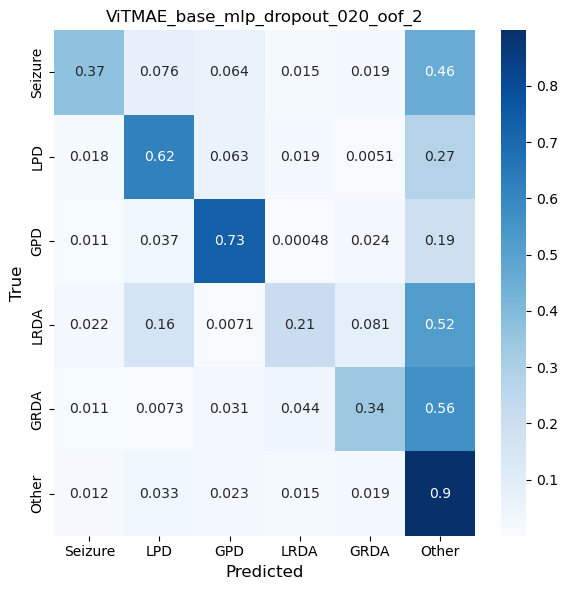

In [10]:
plot_oof = oof_df.copy()

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(plot_oof['target_id'], plot_oof['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

In [ ]:
# new figure
fig, axes = plt.subplots(6, 5, figsize=(18, 16), sharex=True, sharey=True)

plot_oof = oof_df[oof_df['kl_loss'] > 0.2]

for row in range(axes.shape[0]):
    row_selects = plot_oof[plot_oof['target_id']==row]
    target_label = BRAIN_ACTIVITY[row]
    for col in range(axes.shape[1]):
        ax = axes[row, col]
        idx = np.random.choice(row_selects.index)
        df_rows = plot_oof.loc[idx]
        ax.plot(df_rows[TARGETS].values , label='True')
        ax.plot(df_rows[TARGETS_PRED].values, label='Pred')
        ax.set_title(f"{idx} | KL: {df_rows['kl_loss']:.4f} ") #
        ax.set_xticks(range(6))
        ax.set_xticklabels(BRAIN_ACTIVITY)
        ax.grid(True)
        ax.legend()
        if col == 0:
            ax.set_ylabel(target_label, fontsize=12)
       
fig.tight_layout()
plt.show()


